In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pm4py
import scipy
import stormpy
import datetime
import numpy as np
from fitter import Fitter

In [3]:
from simulation.markov_models import log_parser
from simulation.markov_chain import apply as mc_apply
from simulation.markov_chain_vis import view_markov_chain, view_resource_markov_chain, view_non_resource_markov_chain
import simulation.util as sim_util

## Load event log and clean roles

In [4]:
event_log = pm4py.read_xes('BPI_Challenge_2013_incidents.xes.gz')
event_log = event_log.sort_values(['case:concept:name','time:timestamp'])
number_of_traces = event_log['case:concept:name'].nunique()
subset_el = event_log[['case:concept:name','concept:name','time:timestamp','org:resource','org:role']]
subset_el['org:role'] = subset_el['org:role'].fillna('nan_1').apply(lambda x: x.split('_')[0])
subset_el['org:role'] = subset_el['org:role'].replace({'C':'C1','D':'D1','E':'E1'})

/home/akon/.local/lib/python3.8/site-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/7554 [00:00<?, ?it/s]

/tmp/ipykernel_47823/668204579.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_el['org:role'] = subset_el['org:role'].fillna('nan_1').apply(lambda x: x.split('_')[0])
/tmp/ipykernel_47823/668204579.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_el['org:role'] = subset_el['org:role'].replace({'C':'C1','D':'D1','E':'E1'})


## Define the final states
The final states need to be reachable from the start states according to the DFG.
There can be many, but all of them have to point towards the end state.

In [5]:
final_states = ['Completed']

In [6]:
subset_el = pm4py.read_xes('test.xes')
final_states = ['End']

parsing log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

# Discovery

## Start Control Flow Model: Directly Follows Graph

In [7]:
subset_el = pm4py.convert_to_event_log(subset_el)
subset_el = log_parser.add_start_end(subset_el)
dfg, start_activities, end_activities = pm4py.discover_dfg(subset_el)
dfg["end", "start"] = 1

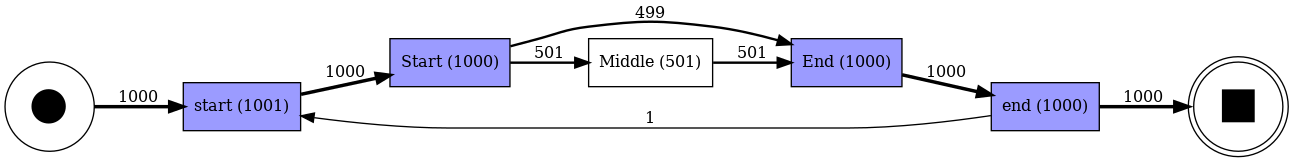

In [8]:
pm4py.view_dfg(dfg, start_activities, end_activities)

In [9]:
subset_el = pm4py.convert_to_dataframe(subset_el)

## (Optional step) Proportional filtering

In [10]:
#TODO: remove arrows in the dfg that account for less than x percent of transitions

## Extract the inputs to the ctmc from the event log

In [11]:
data_transition_role_frequency = sim_util.get_transition_resource_dict(subset_el)

In [12]:
from simulation.timings import Timings

mine_declaratively = True
if mine_declaratively:
    timings = Timings()
    resource_input_array = timings.create_resource_input_array_from_log(subset_el)
    res_timings = timings.get_timings_per_resource(subset_el, resource_input_array)
    times_dictionary = res_timings
else:
    timings = Timings()
    times_dictionary = timings.extract_resource_times_with_future(subset_el)

In [13]:
data_mean_transition_role_time = {}
tuples_to_discard = set()
for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0
        for k3,v3 in v2.items():
            all_freq += v3
            if (k,k2,k3) in times_dictionary:
                times = times_dictionary[(k,k2,k3)]
                times = np.array(times)
                times = times/3600
                times = times[times != 0]
                if len(times) > 1: # only take times that have more than 1 value
                    expon_loc, expon_scale = scipy.stats.expon.fit(times)

                    # f = Fitter(times, distributions=['expon'])
                    # f.fit()
                    # best = f.get_best()['expon']
                    # expon_loc_fitter, expon_scale_fitter = best['loc'], best['scale']

                    if expon_scale>0: # do not take times that cannot be fit into an exponential
                        rate = 1/expon_scale
                        if k not in data_mean_transition_role_time:
                            data_mean_transition_role_time[k] = {}
                        if k2 not in data_mean_transition_role_time[k]:
                            data_mean_transition_role_time[k][k2] = {}
                        if k3 not in data_mean_transition_role_time[k][k2]:
                            data_mean_transition_role_time[k][k2][k3] = {
                                # 'loc': expon_loc_fitter,
                                # 'scale': expon_scale_fitter,
                                'loc': expon_loc,
                                'scale': expon_scale,
                                'lambda': rate
                            }
                    else:
                        print(k,k2,k3)
                        tuples_to_discard.add((k,k2,k3))
                        print(times)
                else:
                    print(k,k2,k3)
                    tuples_to_discard.add((k,k2,k3))
                    print(times)

In [14]:
for (e_from,e_to,role) in tuples_to_discard:
    if e_from in data_transition_role_frequency:
        if e_to in data_transition_role_frequency[e_from]:
            if role in data_transition_role_frequency[e_from][e_to]:
                data_transition_role_frequency[e_from][e_to].pop(role)

In [15]:
for e_from in data_transition_role_frequency.keys():
    for e_to in data_transition_role_frequency.keys():
        if (e_from == 'start' and e_to == 'start') or (e_from == 'end' and e_to == 'end'):
            data_transition_role_frequency[e_from].pop(e_to)

In [16]:
def remove_empty_keys(d):
    """Recursively remove empty keys from a three-level nested dictionary."""
    if not isinstance(d, dict):
        return d  # Return non-dict values as they are

    cleaned_dict = {}
    for key, value in d.items():
        if isinstance(value, dict):
            cleaned_value = remove_empty_keys(value)  # Recursively clean sub-dictionaries
            if cleaned_value:  # Add only if not empty
                cleaned_dict[key] = cleaned_value
        elif value not in (None, "", [], {}, ()):  # Ignore empty values
            cleaned_dict[key] = value

    return cleaned_dict

data_transition_role_frequency = remove_empty_keys(data_transition_role_frequency)

In [17]:
role_resources = sim_util.get_detailed_weighted_role(subset_el)

In [18]:
role_trials = {k:int(v) for k,v in role_resources.items()}

In [19]:
res = {}
out_frequency = {}
data_transition_role_prob = {}

for k,v in data_transition_role_frequency.items():
    if k in ['start','end']:
        continue
    out_freq = 0
    if k not in data_transition_role_prob:
        data_transition_role_prob[k] = {}

    for k2,v2 in v.items():
        if k2 in ['start','end']:
            continue
        all_freq = 0

        if k2 not in data_transition_role_prob[k]:
            data_transition_role_prob[k][k2] = {}

        if k not in res:
            res[k] = {}
        if k2 not in res[k]:
            for k3,v3 in v2.items():
                if k3 not in data_transition_role_prob[k][k2]:
                    data_transition_role_prob[k][k2][k3] = v3
                all_freq += v3
            res[k][k2] = all_freq
            out_freq += all_freq
        out_frequency[k] = out_freq

for k,v in res.items():
    for k2,v2 in v.items():
        res[k][k2] = res[k][k2]/out_frequency[k]

for k,v in data_transition_role_prob.items():
    for k2,v2 in v.items():
        for k3,v3 in v2.items():
            data_transition_role_prob[k][k2][k3] = v3/out_frequency[k]

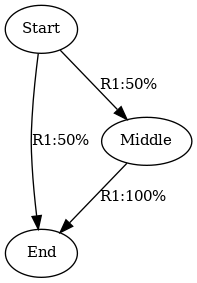

In [20]:
view_resource_markov_chain(data_transition_role_prob)

In [21]:
semi_markov_json = mc_apply(subset_el)

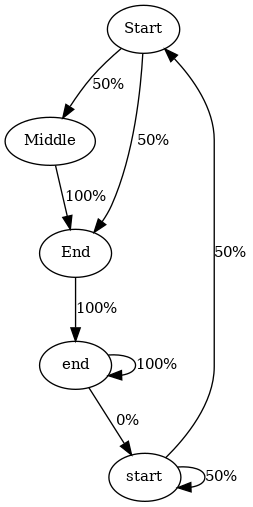

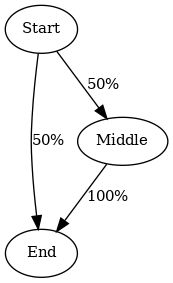

In [22]:
view_markov_chain(semi_markov_json)
view_non_resource_markov_chain(res)

In [23]:
role_resources

{'R1': 1.0}

In [24]:
states = set(subset_el['concept:name'].unique()).difference(set(['start','end']))
n = len(states)
i = 0
correspondence = {s:i for s,i in zip(states,range(len(states)))}
#TODO: make sure none of the final states have state = 0 in the prism program
non_final_states = list(states.difference(set(final_states)))
for s in final_states:
    if correspondence[s] == 0:
        correspondence[s] = correspondence[non_final_states[0]]
        correspondence[non_final_states[0]] = 0
correspondence

{'Start': 0, 'End': 1, 'Middle': 2}

## Analysis for resource allocation

In [25]:
role_resources

{'R1': 1.0}

In [26]:
role_trials = role_resources
role_trials

{'R1': 1.0}

In [28]:
from simulation.ctmc import create_prism_program_from_log

probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc.sm')
# print(probabilities)
prism_program = stormpy.parse_prism_program('ctmc.sm',prism_compat=True,simplify=True)
model = stormpy.build_model(prism_program)
# print("Number of states: {}".format(model.nr_states))
# print("Number of transitions: {}".format(model.nr_transitions))
# print("Labels: {}".format(model.labeling.get_labels()))
labels = ""
for fs in final_states:
    labels += f'"q_terminal_{fs}" |'
labels = labels[:-2]

formula_str = f'Tmin=? [F {labels}]'
properties = stormpy.parse_properties(formula_str, prism_program)
result = stormpy.model_checking(model, properties[0])
initial_state = model.initial_states[0]
result = result.at(initial_state)
print(f"Hours: {result}")
if result<np.inf:
    print(f"Duration: {datetime.timedelta(hours=result)}")

Hours: 3.931757385862124
Duration: 3:55:54.326589


In [29]:
mean, median, margin_of_error = sim_util.get_pm4py_reference_times(subset_el)
print(datetime.timedelta(seconds=median))
print(datetime.timedelta(seconds=mean))
print(datetime.timedelta(seconds=margin_of_error))

4:46:45.509445
6:03:13.455925
0:20:19.989018


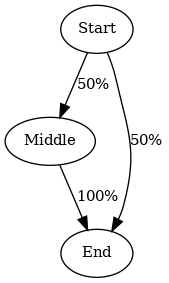

In [30]:
view_non_resource_markov_chain(probabilities)

In [32]:
import random

durations = []
x = list(range(1,50))
samples = 500
for i in range(samples):
    role_trials = {
        'R1': random.choice(x)
        # "A2": random.choice(x),
        # "C1": random.choice(x),
        # "D1": random.choice(x),
        # "E1": random.choice(x),
        # "V3": random.choice(x),
        # "nan": random.choice(x)
    }
    print(role_trials)
    probabilities = create_prism_program_from_log(
                            correspondence,
                            final_states,
                            data_mean_transition_role_time,
                            role_resources,
                            data_transition_role_frequency,
                            role_trials,
                            'ctmc.sm')
    prism_program = stormpy.parse_prism_program('ctmc.sm', prism_compat=True, simplify=True)
    model = stormpy.build_model(prism_program)
    labels = ""
    for fs in final_states:
        labels += f'"q_terminal_{fs}" |'
    labels = labels[:-2]

    formula_str = f'Tmin=? [F {labels}]'
    properties = stormpy.parse_properties(formula_str, prism_program)
    result = stormpy.model_checking(model, properties[0])
    initial_state = model.initial_states[0]
    result = result.at(initial_state)
    durations.append({**role_trials, "duration": result})
    print(f'{i}/{samples}')

{'R1': 40}
0/500
{'R1': 47}
1/500
{'R1': 13}
2/500
{'R1': 37}
3/500
{'R1': 26}
4/500
{'R1': 34}
5/500
{'R1': 36}
6/500
{'R1': 38}
7/500
{'R1': 4}
8/500
{'R1': 29}
9/500
{'R1': 24}
10/500
{'R1': 44}
11/500
{'R1': 20}
12/500
{'R1': 9}
13/500
{'R1': 33}
14/500
{'R1': 31}
15/500
{'R1': 11}
16/500
{'R1': 10}
17/500
{'R1': 8}
18/500
{'R1': 30}
19/500
{'R1': 13}
20/500
{'R1': 19}
21/500
{'R1': 33}
22/500
{'R1': 35}
23/500
{'R1': 26}
24/500
{'R1': 5}
25/500
{'R1': 31}
26/500
{'R1': 18}
27/500
{'R1': 43}
28/500
{'R1': 18}
29/500
{'R1': 48}
30/500
{'R1': 37}
31/500
{'R1': 37}
32/500
{'R1': 29}
33/500
{'R1': 19}
34/500
{'R1': 1}
35/500
{'R1': 14}
36/500
{'R1': 4}
37/500
{'R1': 21}
38/500
{'R1': 28}
39/500
{'R1': 14}
40/500
{'R1': 45}
41/500
{'R1': 18}
42/500
{'R1': 43}
43/500
{'R1': 32}
44/500
{'R1': 15}
45/500
{'R1': 44}
46/500
{'R1': 24}
47/500
{'R1': 9}
48/500
{'R1': 43}
49/500
{'R1': 22}
50/500
{'R1': 16}
51/500
{'R1': 48}
52/500
{'R1': 14}
53/500
{'R1': 30}
54/500
{'R1': 44}
55/500
{'R1': 30

## Find the under estimation coeficient for the specific log

In [33]:
from copy import deepcopy
from pm4py.algo.filtering.log.variants import variants_filter

In [34]:
scales = [2**i for i in range(-5, 6)]  # -5 to 5 gives 1/32x to 32x
labels = [f"{s}x" if s >= 1 else f"1/{int(1/s)}x" for s in scales]
sc_data = {}
for scale, label in zip(scales, labels):
    print(label)
    el = sim_util.scale_event_log_time(deepcopy(subset_el), multiplicity=scale)
    sc_data[label] = el
    filtered_el = pm4py.convert_to_dataframe(variants_filter.filter_log_variants_percentage(deepcopy(el),percentage=0.8))
    sc_data[f'filtered-{label}'] = filtered_el

1/32x
1/16x
1/8x
1/4x
1/2x
1x
2x
4x
8x
16x
32x


In [35]:
sc_df = sim_util.sanity_check(sc_data,final_states)

Start End R1
[]
Start Middle R1
[1.]
Middle End R1
[]
Reference times
[1/32x] Mean: 0:11:21.045498
[1/32x] Std: 0:00:38.124657
[1/32x] median: 0:08:57.672170

ERROR (SparseMarkovAutomatonCslModelChecker.cpp:210): Formula needs to specify whether minimal or maximal values are to be computed on nondeterministic model.


RuntimeError: InvalidPropertyException: Formula needs to specify whether minimal or maximal values are to be computed on nondeterministic model.

In [ ]:
sc_df[['label','ref-mean','ref-median','analysis-time','offset']]

In [ ]:
import matplotlib.pyplot as plt

el = []
el_errors = []
ctmc_el = []
el_filtered = []
el_filtered_errors = []
ctmc_elf = []
x = [i for i in range(len(scales))]
for i,row in sc_df.iterrows():
    if str(row['label']).startswith('filtered'):
        el_filtered.append(row['ref-median'].total_seconds()//3600)
        el_filtered_errors.append(row['ref-std'].total_seconds()//3600)
        ctmc_elf.append(row['analysis-time'].total_seconds()//3600)
    else:
        el.append(row['ref-median'].total_seconds()//3600)
        el_errors.append(row['ref-std'].total_seconds()//3600)
        ctmc_el.append(row['analysis-time'].total_seconds()//3600)

el = np.array(el)
el_errors = np.array(el_errors)
ctmc_el = np.array(ctmc_el)
el_filtered = np.array(el_filtered)
el_filtered_errors = np.array(el_filtered_errors)
ctmc_elf = np.array(ctmc_elf)

log_el = np.log(el)
log_el_errors = np.log(el_errors)
log_ctmc_el = np.log(ctmc_el)
log_el_filtered = np.log(el_filtered)
log_el_filtered_errors = np.log(el_filtered_errors)
log_ctmc_elf = np.log(ctmc_elf)

plt.figure(1,(16,4))

plt.scatter(x,log_el, color='r',marker='.')
plt.plot(x,log_el,label='el median',color='r',linestyle='-', marker='.')
plt.fill_between(x, log_el - log_el_errors, log_el + log_el_errors, alpha=0.2, color='r')

plt.scatter(x,log_ctmc_el, color='b',marker='v')
plt.plot(x,log_ctmc_el,label='ctmc-el', color='b',marker='v',linestyle='--')

plt.scatter(x,log_el_filtered, color='g',marker='s',s=10)
plt.plot(x,log_el_filtered,label='el-filtered median', color='g',marker='s',linestyle=':')
plt.fill_between(x, log_el_filtered - log_el_filtered_errors, log_el_filtered + log_el_filtered_errors, alpha=0.2, color='g')

plt.scatter(x,log_ctmc_elf, color='orange',marker='*',)
plt.plot(x,log_ctmc_elf,label='ctmc-elf', color='orange',marker='*',linestyle='-.')

plt.xticks(x,labels)
plt.xlabel('event log duration time scale')
plt.ylabel('duration (hours,log scale)')
plt.title('BIC 13 log')
plt.legend()

## Find regression coeficients

In [ ]:
import pandas as pd

durations_df = pd.DataFrame(durations)
durations_df

## Save the configurations

In [ ]:
import json

with open('mean_transition_role_time.json', 'w') as file:
    json.dump(data_mean_transition_role_time, file, indent=4)

with open('role_number_of_resources.json', 'w') as file:
    json.dump(role_resources, file, indent=4)

with open('transition_role_frequency.json', 'w') as file:
    json.dump(data_transition_role_frequency, file, indent=4)

role_trials = {k:int(v) for k,v in role_resources.items()}
with open('role_trials.json', 'w') as file:
    json.dump(role_trials, file, indent=4)

# Evaluation

##

## Analyze timings for specific roles
TODO: run a ks or chi-square test between the fitted functions to analyze the goodness of fit

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import fitter
from simulation.markov_models.fit_distribution import fit_gauss

import scipy.stats as stats
from scipy.stats import entropy as kl_div

2025-05-01 11:03:36.568 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.161146)
2025-05-01 11:03:36.663 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.363848)
2025-05-01 11:03:36.719 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=0.230968)
2025-05-01 11:03:36.776 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted exponpow distribution with error=0.209319)
2025-05-01 11:03:36.848 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.40203)
2025-05-01 11:03:36.849 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.35874)
2025-05-01 11:03:36.856 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.30788)
2025-05-01 11:03:36.886 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayl

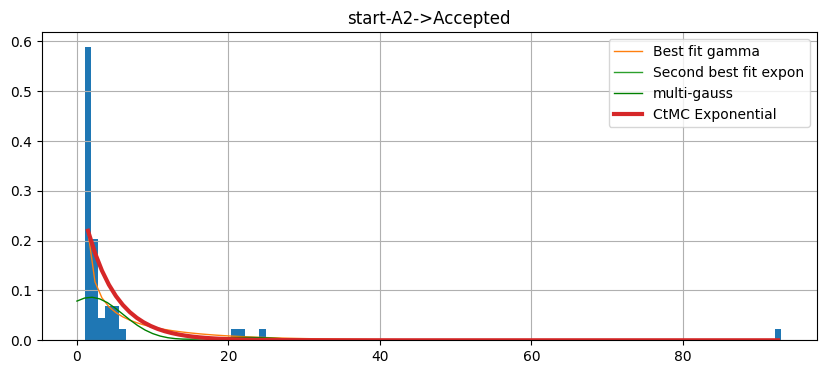

2025-05-01 11:03:37.883 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.681965)
2025-05-01 11:03:37.883 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.708383)
2025-05-01 11:03:37.883 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.667331)
2025-05-01 11:03:37.885 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.671775)
2025-05-01 11:03:37.888 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.585344)
2025-05-01 11:03:38.499 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.412477)
2025-05-01 11:03:38.524 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.725249)
2025-05-01 11:03:38.530 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

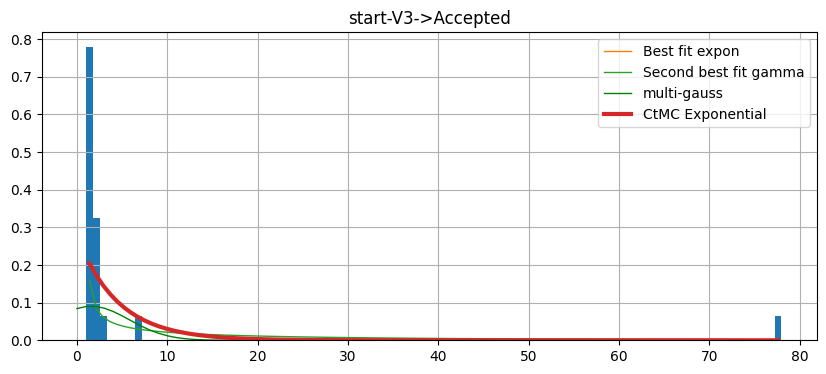

2025-05-01 11:03:38.920 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=1218.20321)
2025-05-01 11:03:38.922 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=1237.447235)
2025-05-01 11:03:38.923 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=1236.514942)
2025-05-01 11:03:38.924 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=1065.952517)
2025-05-01 11:03:38.924 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=1225.0)
2025-05-01 11:03:38.925 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=1166.967594)
2025-05-01 11:03:38.926 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=1238.956984)
2025-05-01 11:03:38.932 | INFO     | fitter.fitter:_fit_single_distribut

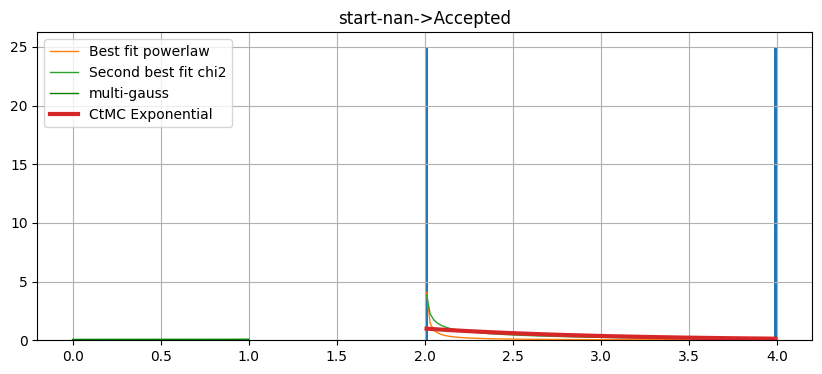

2025-05-01 11:03:39.396 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=64.751486)
2025-05-01 11:03:39.398 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=68.317275)
2025-05-01 11:03:39.399 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=67.598583)
2025-05-01 11:03:39.399 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=68.0839)
2025-05-01 11:03:39.400 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=68.015196)
2025-05-01 11:03:39.401 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=52.502131)
2025-05-01 11:03:39.402 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=62.606093)
2025-05-01 11:03:39.429 | INFO     | fitter.fitter:_fit_single_distribution:333 - 

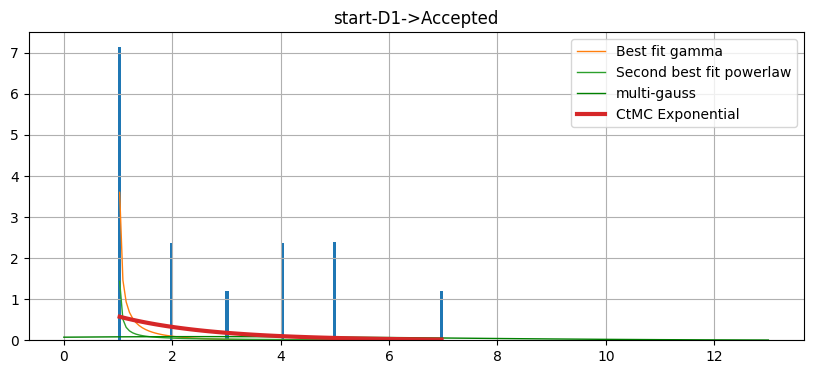

2025-05-01 11:03:39.777 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.034117)
2025-05-01 11:03:39.779 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.048647)
2025-05-01 11:03:39.780 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.047732)
2025-05-01 11:03:39.780 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.050678)
2025-05-01 11:03:39.781 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.014701)
2025-05-01 11:03:39.783 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.047277)
2025-05-01 11:03:39.784 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.041274)
2025-05-01 11:03:39.807 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

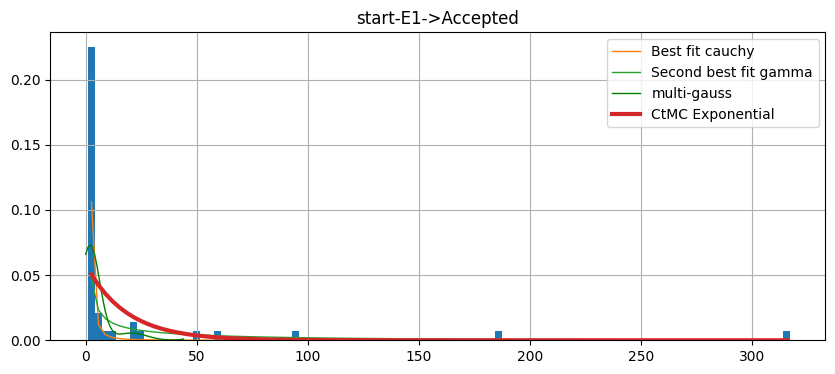

2025-05-01 11:03:40.436 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4e-06)
2025-05-01 11:03:40.437 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=2e-05)
2025-05-01 11:03:40.438 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=1.9e-05)
2025-05-01 11:03:40.438 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=2.5e-05)
2025-05-01 11:03:40.443 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=1.9e-05)
2025-05-01 11:03:40.446 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=2.2e-05)
2025-05-01 11:03:40.447 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=1.5e-05)
2025-05-01 11:03:40.472 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 dist

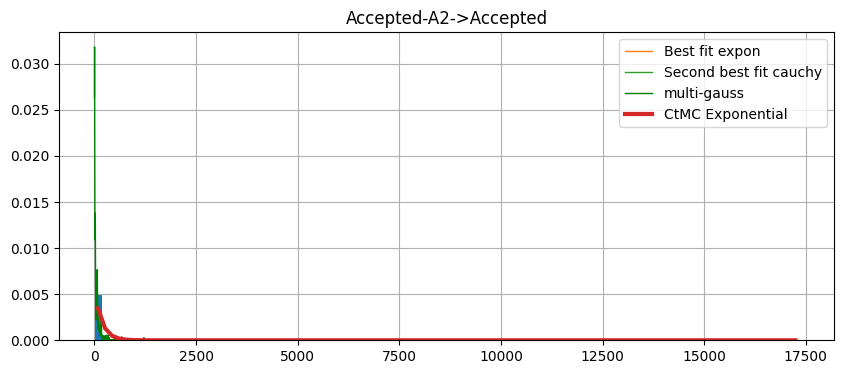

2025-05-01 11:03:55.418 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4.4e-05)
2025-05-01 11:03:55.419 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000242)
2025-05-01 11:03:55.420 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000314)
2025-05-01 11:03:55.420 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000218)
2025-05-01 11:03:55.428 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.8e-05)
2025-05-01 11:03:55.428 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000224)
2025-05-01 11:03:55.429 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000276)
2025-05-01 11:03:55.463 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

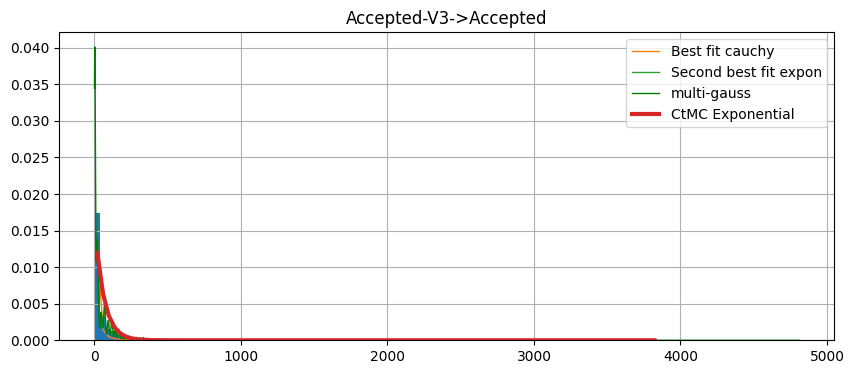

2025-05-01 11:04:05.600 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000256)
2025-05-01 11:04:05.601 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000479)
2025-05-01 11:04:05.602 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000461)
2025-05-01 11:04:05.602 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000524)
2025-05-01 11:04:05.604 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.00037)
2025-05-01 11:04:05.606 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=3.2e-05)
2025-05-01 11:04:05.607 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000459)
2025-05-01 11:04:05.623 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

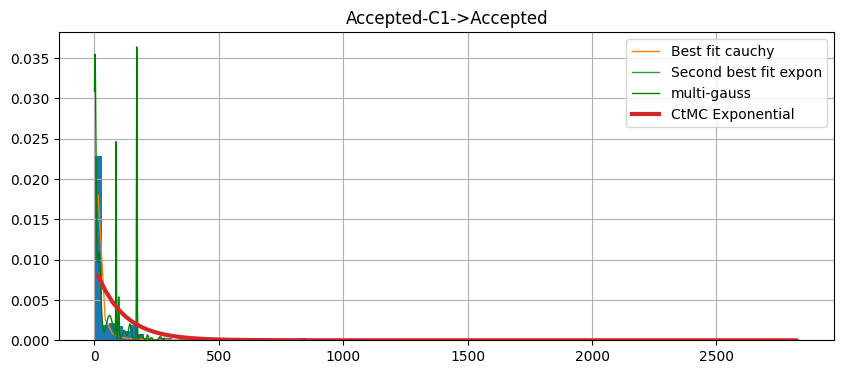

2025-05-01 11:04:18.495 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=2.9e-05)
2025-05-01 11:04:18.496 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000242)
2025-05-01 11:04:18.497 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000318)
2025-05-01 11:04:18.498 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000216)
2025-05-01 11:04:18.502 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000225)
2025-05-01 11:04:18.504 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000277)
2025-05-01 11:04:18.504 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.2e-05)
2025-05-01 11:04:18.540 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

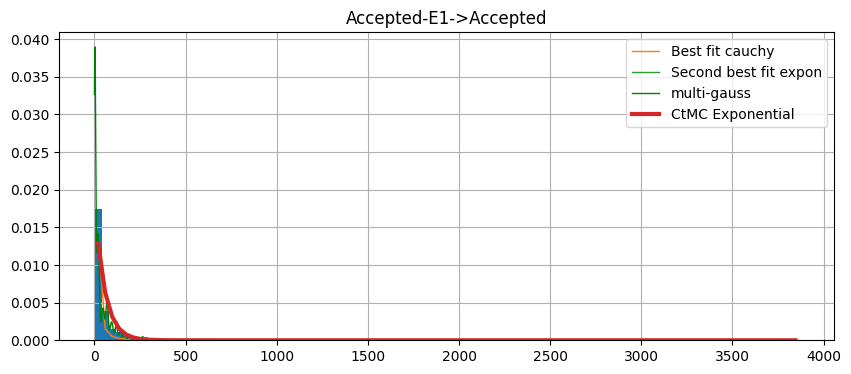

2025-05-01 11:04:22.955 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3e-05)
2025-05-01 11:04:22.956 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=9.4e-05)
2025-05-01 11:04:22.956 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=8.4e-05)
2025-05-01 11:04:22.960 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=8e-05)
2025-05-01 11:04:22.961 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=3.2e-05)
2025-05-01 11:04:22.963 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=7e-05)
2025-05-01 11:04:22.965 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=8.3e-05)
2025-05-01 11:04:22.985 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distri

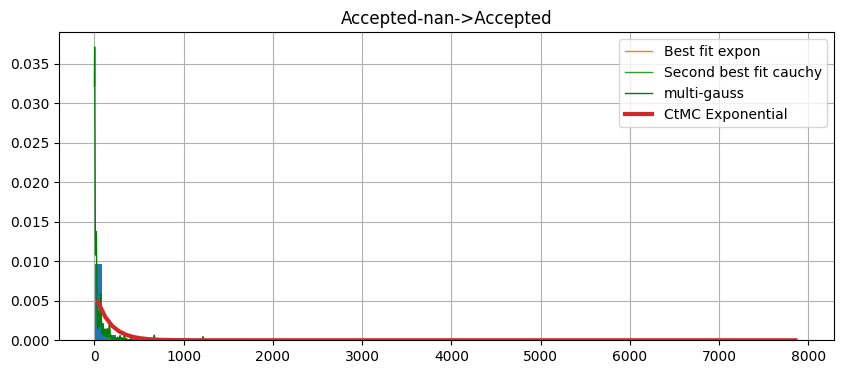

2025-05-01 11:04:31.274 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.00038)
2025-05-01 11:04:31.275 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000898)
2025-05-01 11:04:31.276 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000786)
2025-05-01 11:04:31.276 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000747)
2025-05-01 11:04:31.278 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.00076)
2025-05-01 11:04:31.278 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=6.3e-05)
2025-05-01 11:04:31.279 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000576)
2025-05-01 11:04:31.304 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted c

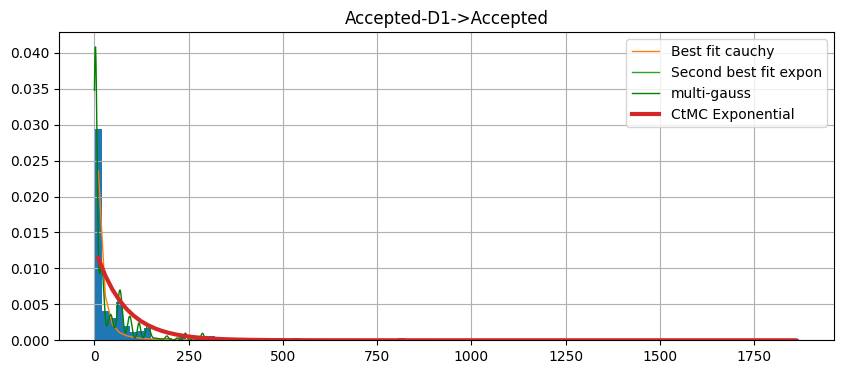

2025-05-01 11:09:04.084 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3.8e-05)
2025-05-01 11:09:04.086 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000196)
2025-05-01 11:09:04.086 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000236)
2025-05-01 11:09:04.086 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000182)
2025-05-01 11:09:04.090 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000211)
2025-05-01 11:09:04.090 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=7.8e-05)
2025-05-01 11:09:04.092 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000179)
2025-05-01 11:09:04.125 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

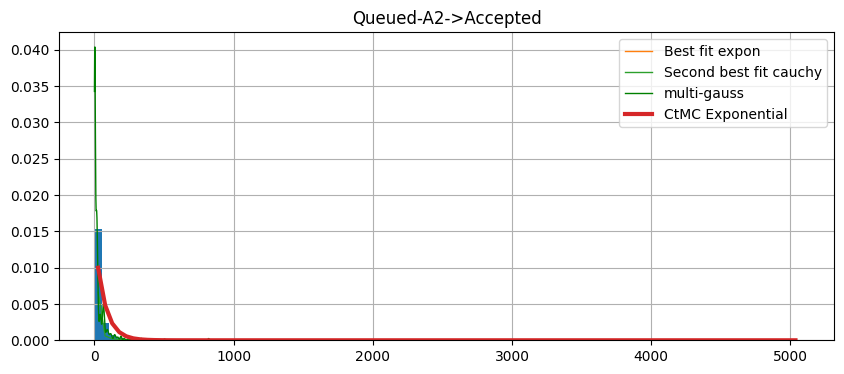

2025-05-01 11:09:11.945 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3e-06)
2025-05-01 11:09:11.948 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000106)
2025-05-01 11:09:11.952 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000153)
2025-05-01 11:09:11.956 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000138)
2025-05-01 11:09:11.960 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=8.8e-05)
2025-05-01 11:09:11.961 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=6.9e-05)
2025-05-01 11:09:11.965 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000119)
2025-05-01 11:09:12.036 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gam

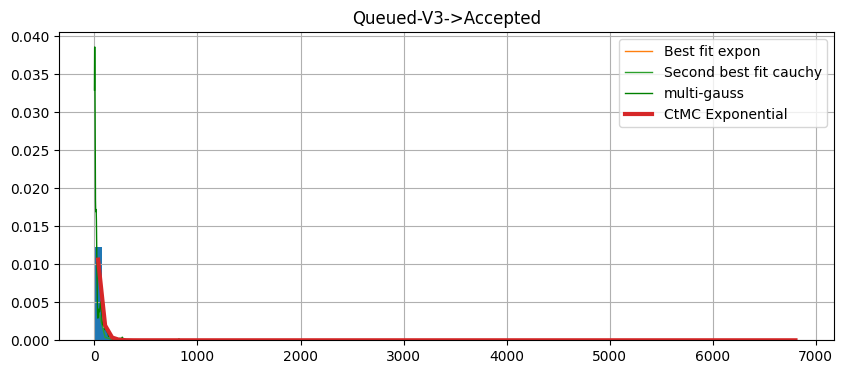

2025-05-01 11:09:16.149 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000235)
2025-05-01 11:09:16.151 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000594)
2025-05-01 11:09:16.153 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000663)
2025-05-01 11:09:16.153 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000566)
2025-05-01 11:09:16.154 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=3.4e-05)
2025-05-01 11:09:16.155 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000584)
2025-05-01 11:09:16.156 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000478)
2025-05-01 11:09:16.182 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

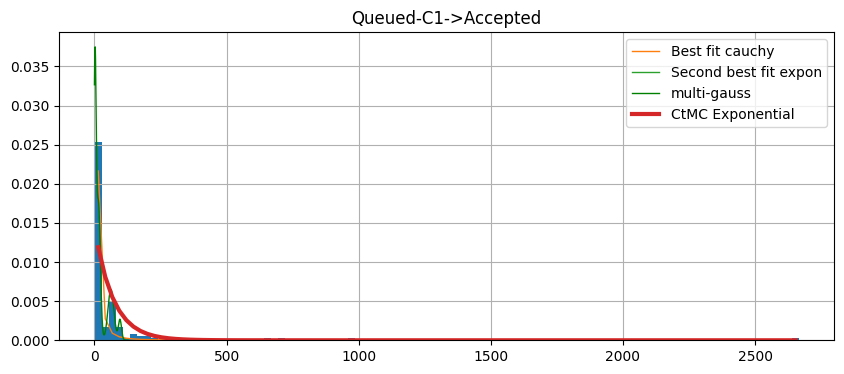

2025-05-01 11:09:17.635 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=1.5e-05)
2025-05-01 11:09:17.637 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000274)
2025-05-01 11:09:17.638 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000372)
2025-05-01 11:09:17.638 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.00024)
2025-05-01 11:09:17.641 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000275)
2025-05-01 11:09:17.641 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=6.3e-05)
2025-05-01 11:09:17.644 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.00033)
2025-05-01 11:09:17.663 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted ch

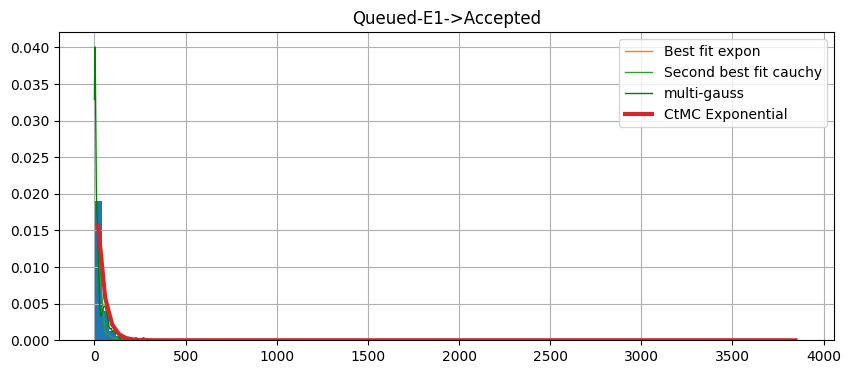

2025-05-01 11:09:20.579 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000126)
2025-05-01 11:09:20.580 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000358)
2025-05-01 11:09:20.580 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000315)
2025-05-01 11:09:20.582 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000299)
2025-05-01 11:09:20.583 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2e-05)
2025-05-01 11:09:20.583 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000255)
2025-05-01 11:09:20.586 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000314)
2025-05-01 11:09:20.617 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted g

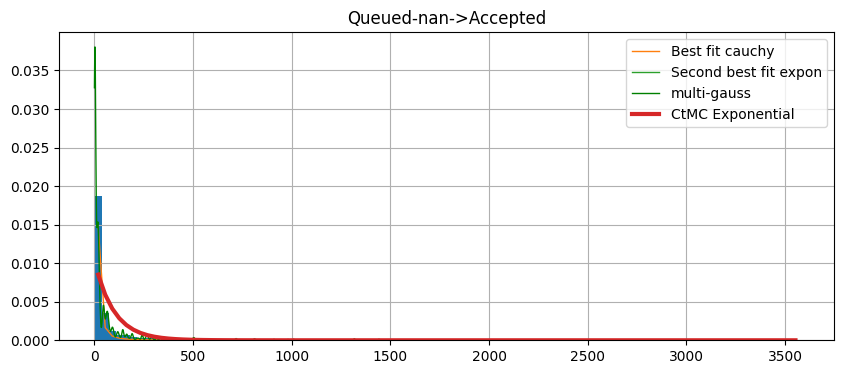

2025-05-01 11:09:28.886 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.00619)
2025-05-01 11:09:28.888 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.013834)
2025-05-01 11:09:28.889 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.016863)
2025-05-01 11:09:28.890 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.012973)
2025-05-01 11:09:28.891 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.005981)
2025-05-01 11:09:28.891 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.014251)
2025-05-01 11:09:28.891 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.01)
2025-05-01 11:09:28.917 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gam

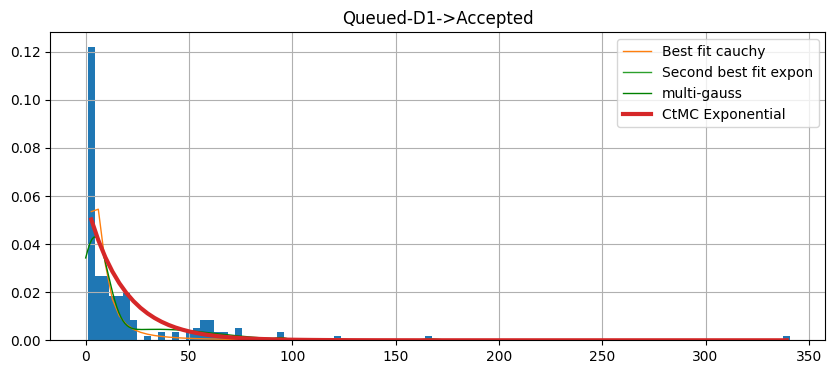

2025-05-01 11:09:30.169 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000705)
2025-05-01 11:09:30.170 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.001395)
2025-05-01 11:09:30.170 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.001195)
2025-05-01 11:09:30.171 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.001134)
2025-05-01 11:09:30.172 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000906)
2025-05-01 11:09:30.173 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000405)
2025-05-01 11:09:30.176 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000896)
2025-05-01 11:09:30.200 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

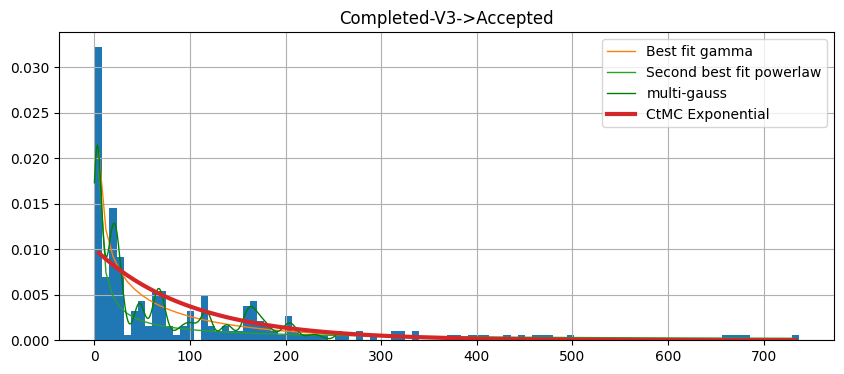

2025-05-01 11:09:39.559 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.010337)
2025-05-01 11:09:39.560 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.00878)
2025-05-01 11:09:39.560 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.010179)
2025-05-01 11:09:39.561 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.010438)
2025-05-01 11:09:39.561 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.008117)
2025-05-01 11:09:39.561 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.004621)
2025-05-01 11:09:39.564 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.010038)
2025-05-01 11:09:39.585 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

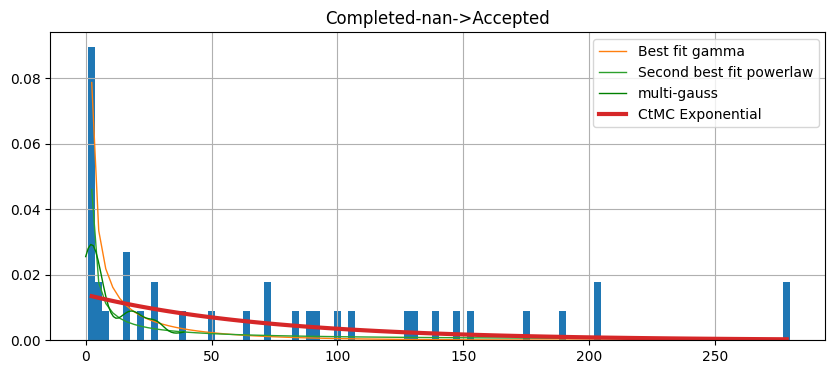

2025-05-01 11:09:40.979 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000976)
2025-05-01 11:09:40.980 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.001526)
2025-05-01 11:09:40.980 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.001597)
2025-05-01 11:09:40.981 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.001785)
2025-05-01 11:09:40.982 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.00058)
2025-05-01 11:09:40.984 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.00103)
2025-05-01 11:09:40.987 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.001253)
2025-05-01 11:09:41.002 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

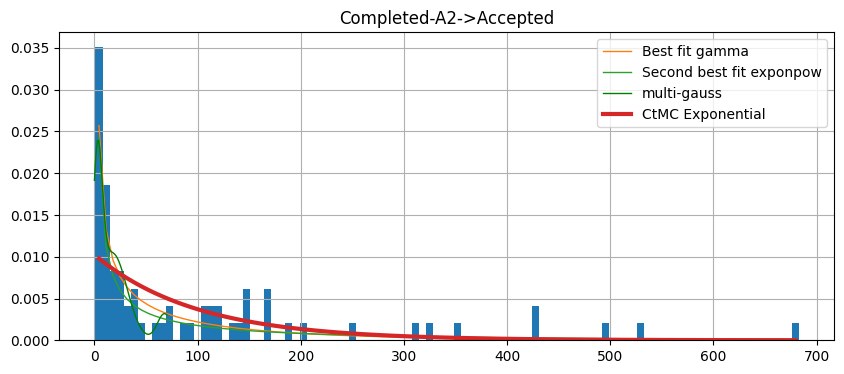

2025-05-01 11:09:44.600 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.007306)
2025-05-01 11:09:44.600 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.008004)
2025-05-01 11:09:44.602 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.007949)
2025-05-01 11:09:44.603 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.007894)
2025-05-01 11:09:44.604 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.005749)
2025-05-01 11:09:44.606 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.006899)
2025-05-01 11:09:44.606 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.007696)
2025-05-01 11:09:44.624 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

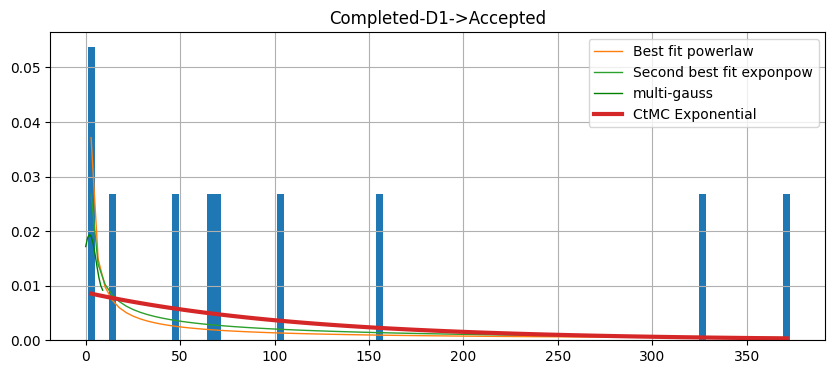

2025-05-01 11:09:45.222 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.0005)
2025-05-01 11:09:45.223 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.001033)
2025-05-01 11:09:45.225 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.00122)
2025-05-01 11:09:45.225 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000972)
2025-05-01 11:09:45.225 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000412)
2025-05-01 11:09:45.226 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000846)
2025-05-01 11:09:45.227 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000486)
2025-05-01 11:09:45.249 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted c

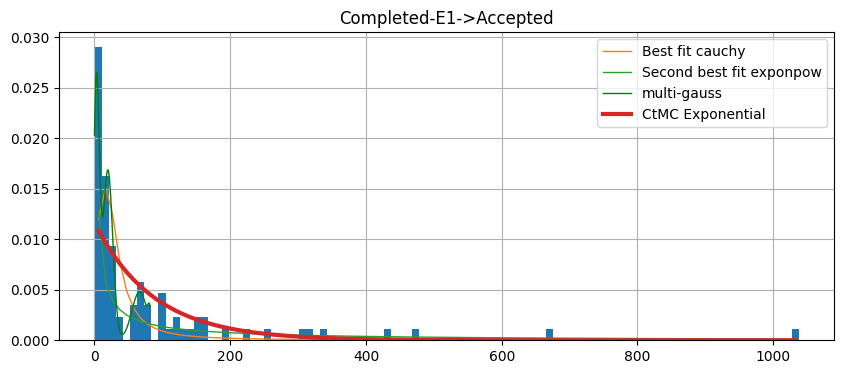

2025-05-01 11:09:48.832 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.003065)
2025-05-01 11:09:48.834 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.00445)
2025-05-01 11:09:48.834 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.004679)
2025-05-01 11:09:48.834 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.004336)
2025-05-01 11:09:48.838 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.001354)
2025-05-01 11:09:48.839 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.004288)
2025-05-01 11:09:48.840 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.003554)
2025-05-01 11:09:48.852 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

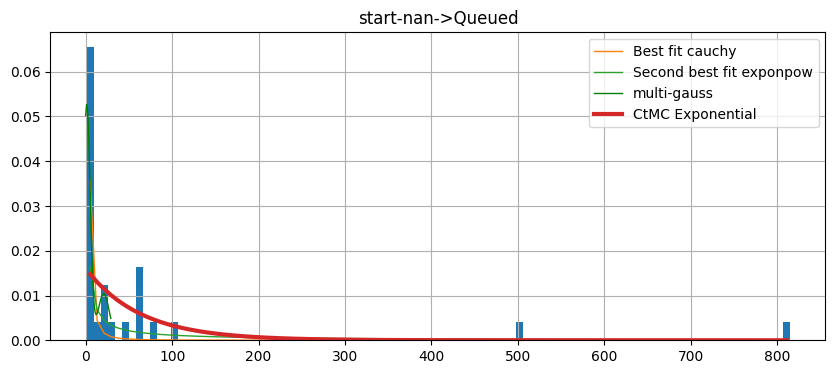

2025-05-01 11:09:49.396 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.233198)
2025-05-01 11:09:49.398 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.25006)
2025-05-01 11:09:49.400 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.249946)
2025-05-01 11:09:49.400 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.248747)
2025-05-01 11:09:49.404 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.20619)
2025-05-01 11:09:49.405 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.236023)
2025-05-01 11:09:49.414 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.257128)
2025-05-01 11:09:49.421 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

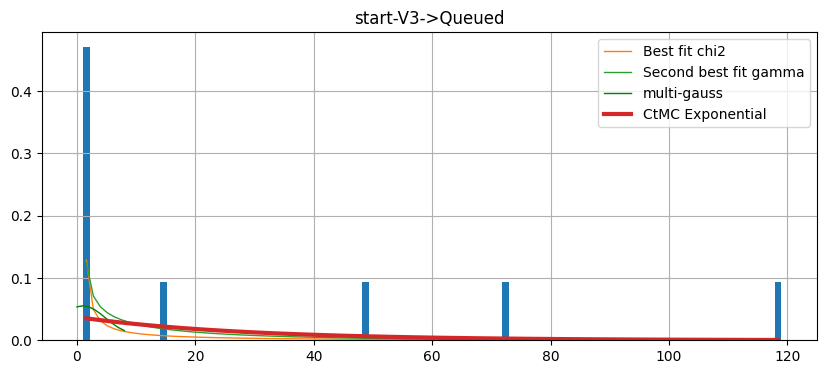

2025-05-01 11:09:49.754 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.008129)
2025-05-01 11:09:49.755 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.010143)
2025-05-01 11:09:49.756 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.010566)
2025-05-01 11:09:49.756 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.009965)
2025-05-01 11:09:49.761 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.006982)
2025-05-01 11:09:49.761 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.00539)
2025-05-01 11:09:49.762 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.00923)
2025-05-01 11:09:49.786 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

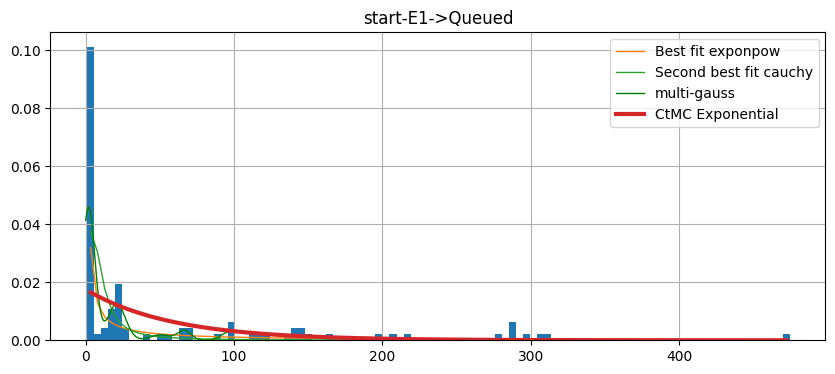

2025-05-01 11:09:50.995 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.023545)
2025-05-01 11:09:50.998 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.028556)
2025-05-01 11:09:50.999 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.029324)
2025-05-01 11:09:50.999 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.012194)
2025-05-01 11:09:50.999 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.028133)
2025-05-01 11:09:51.002 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.020688)
2025-05-01 11:09:51.002 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.026108)
2025-05-01 11:09:51.016 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

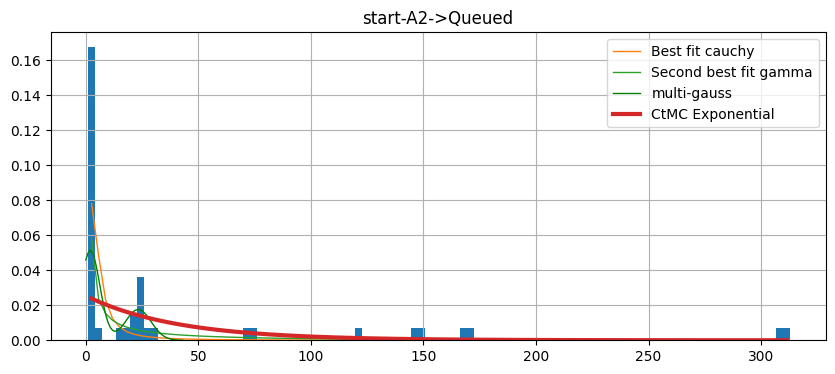

2025-05-01 11:09:51.620 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=1.8e-05)
2025-05-01 11:09:51.622 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=9.8e-05)
2025-05-01 11:09:51.622 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=9.2e-05)
2025-05-01 11:09:51.622 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000112)
2025-05-01 11:09:51.625 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=5.5e-05)
2025-05-01 11:09:51.625 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000102)
2025-05-01 11:09:51.629 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=8.7e-05)
2025-05-01 11:09:51.645 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi

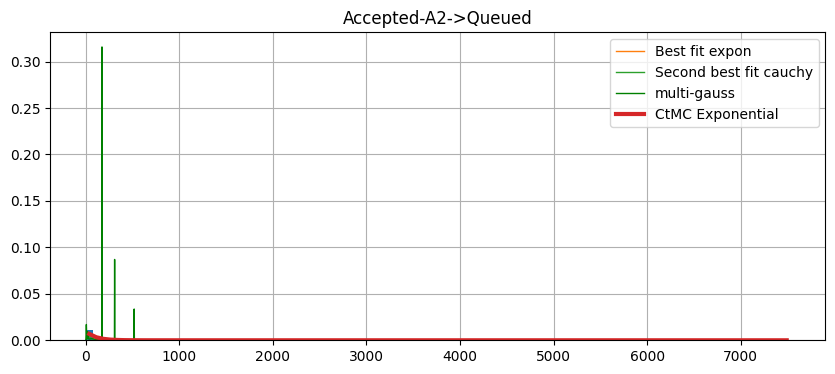

2025-05-01 11:12:11.844 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000213)
2025-05-01 11:12:11.845 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000596)
2025-05-01 11:12:11.847 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000708)
2025-05-01 11:12:11.848 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000558)
2025-05-01 11:12:11.850 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000634)
2025-05-01 11:12:11.851 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000523)
2025-05-01 11:12:11.852 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=9.7e-05)
2025-05-01 11:12:11.882 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

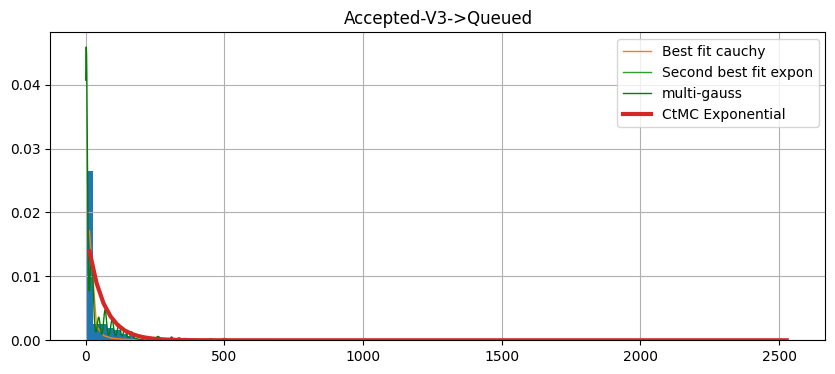

2025-05-01 11:12:23.894 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000433)
2025-05-01 11:12:23.894 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000752)
2025-05-01 11:12:23.895 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000724)
2025-05-01 11:12:23.896 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000819)
2025-05-01 11:12:23.900 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000179)
2025-05-01 11:12:23.900 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000677)
2025-05-01 11:12:23.901 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000467)
2025-05-01 11:12:23.914 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

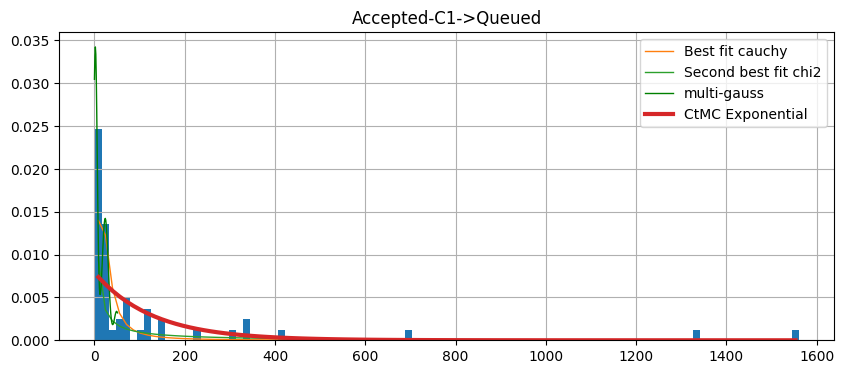

2025-05-01 11:12:25.558 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000183)
2025-05-01 11:12:25.559 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000619)
2025-05-01 11:12:25.559 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000748)
2025-05-01 11:12:25.560 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000575)
2025-05-01 11:12:25.563 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000675)
2025-05-01 11:12:25.564 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000216)
2025-05-01 11:12:25.565 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000564)
2025-05-01 11:12:25.580 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

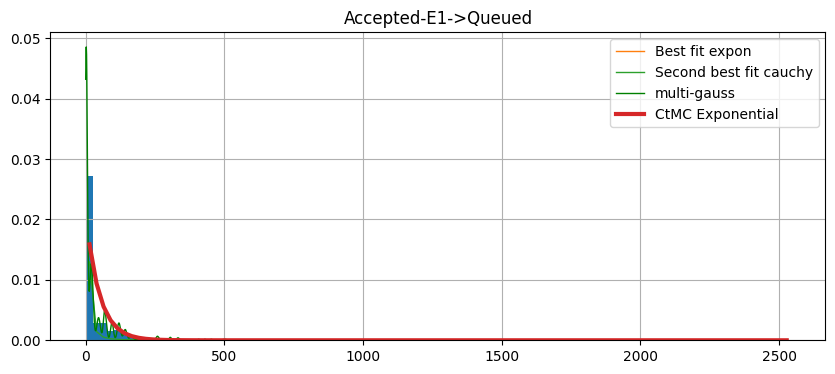

2025-05-01 11:12:37.499 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=2.7e-05)
2025-05-01 11:12:37.502 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=8.6e-05)
2025-05-01 11:12:37.503 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=9.6e-05)
2025-05-01 11:12:37.503 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=8.2e-05)
2025-05-01 11:12:37.504 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=8.7e-05)
2025-05-01 11:12:37.505 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=3.1e-05)
2025-05-01 11:12:37.506 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=7.3e-05)
2025-05-01 11:12:37.524 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 

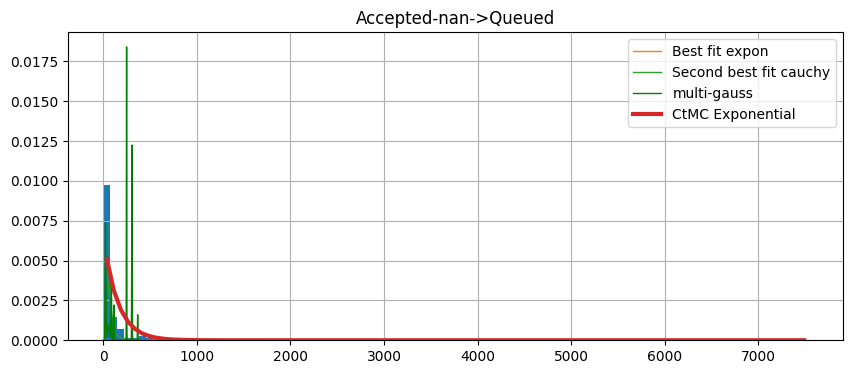

2025-05-01 11:13:00.416 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.020995)
2025-05-01 11:13:00.418 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.026204)
2025-05-01 11:13:00.418 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.024823)
2025-05-01 11:13:00.418 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.025183)
2025-05-01 11:13:00.419 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.01745)
2025-05-01 11:13:00.420 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.005299)
2025-05-01 11:13:00.421 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.022657)
2025-05-01 11:13:00.437 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

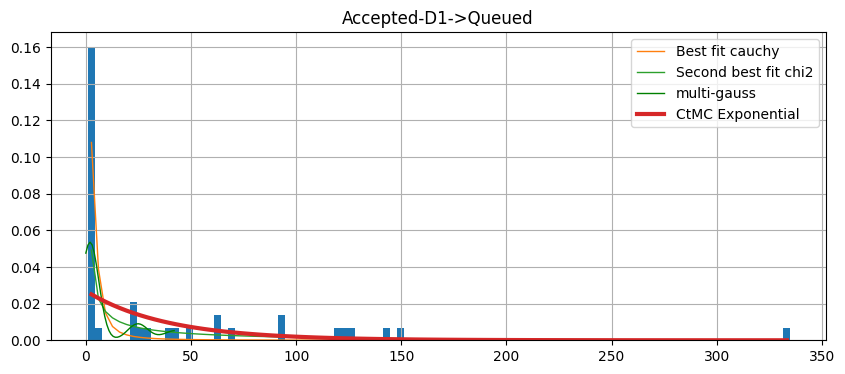

2025-05-01 11:13:01.033 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000368)
2025-05-01 11:13:01.034 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000977)
2025-05-01 11:13:01.034 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.001163)
2025-05-01 11:13:01.035 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000916)
2025-05-01 11:13:01.037 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=3e-05)
2025-05-01 11:13:01.040 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000995)
2025-05-01 11:13:01.040 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.00076)
2025-05-01 11:13:01.056 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted ch

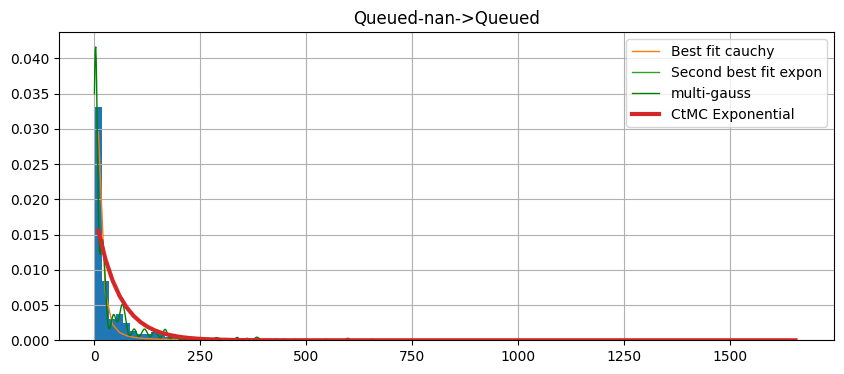

2025-05-01 11:13:10.633 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=1.7e-05)
2025-05-01 11:13:10.635 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=6.1e-05)
2025-05-01 11:13:10.635 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=5.7e-05)
2025-05-01 11:13:10.635 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=7e-05)
2025-05-01 11:13:10.638 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=1.1e-05)
2025-05-01 11:13:10.640 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=5e-05)
2025-05-01 11:13:10.641 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=6e-05)
2025-05-01 11:13:10.657 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distri

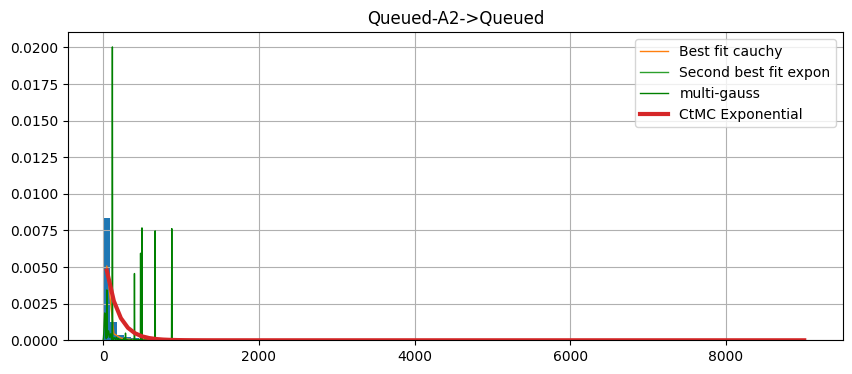

2025-05-01 11:13:25.618 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=3.1e-05)
2025-05-01 11:13:25.620 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=9.7e-05)
2025-05-01 11:13:25.620 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000107)
2025-05-01 11:13:25.622 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=9.2e-05)
2025-05-01 11:13:25.623 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=7.8e-05)
2025-05-01 11:13:25.624 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=3.5e-05)
2025-05-01 11:13:25.625 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=9.4e-05)
2025-05-01 11:13:25.642 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamm

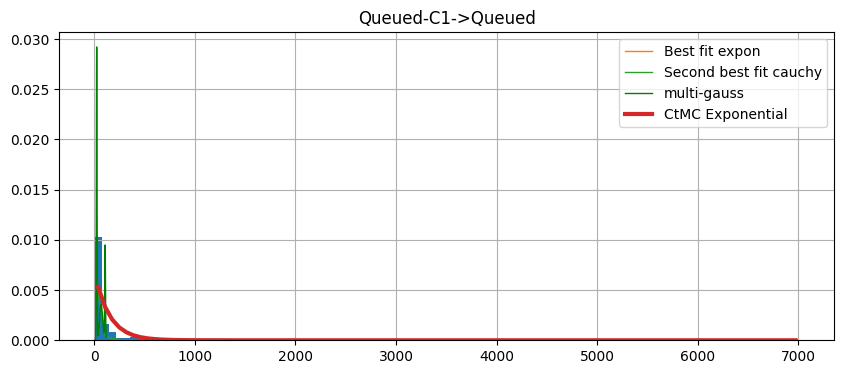

2025-05-01 11:13:38.638 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=9.3e-05)
2025-05-01 11:13:38.640 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000439)
2025-05-01 11:13:38.640 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000338)
2025-05-01 11:13:38.641 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000307)
2025-05-01 11:13:38.643 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=4.4e-05)
2025-05-01 11:13:38.645 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000347)
2025-05-01 11:13:38.646 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000255)
2025-05-01 11:13:38.672 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

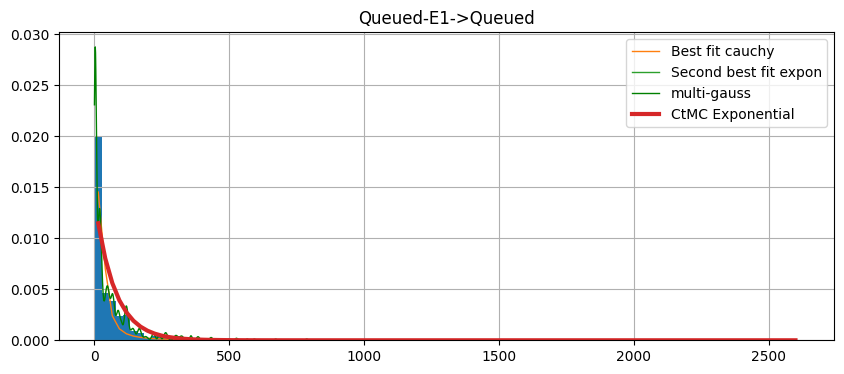

2025-05-01 11:13:53.111 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000173)
2025-05-01 11:13:53.113 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000627)
2025-05-01 11:13:53.115 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000792)
2025-05-01 11:13:53.115 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000575)
2025-05-01 11:13:53.115 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.8e-05)
2025-05-01 11:13:53.116 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000686)
2025-05-01 11:13:53.118 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000549)
2025-05-01 11:13:53.147 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

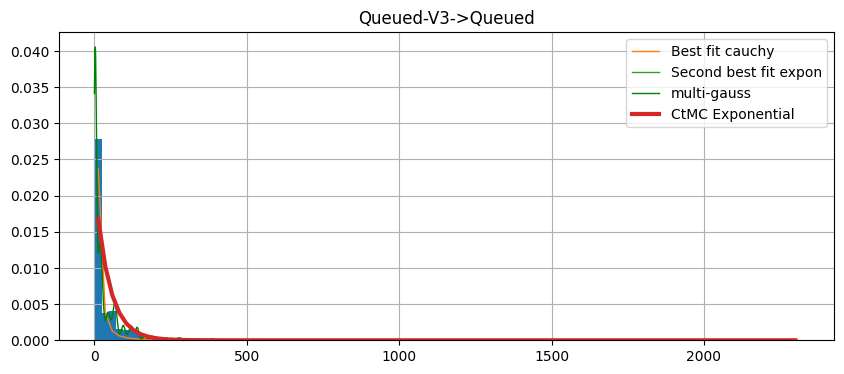

2025-05-01 11:13:58.434 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.020524)
2025-05-01 11:13:58.435 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.030167)
2025-05-01 11:13:58.435 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.028316)
2025-05-01 11:13:58.437 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.027697)
2025-05-01 11:13:58.439 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.002082)
2025-05-01 11:13:58.439 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.020914)
2025-05-01 11:13:58.441 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.026529)
2025-05-01 11:13:58.489 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

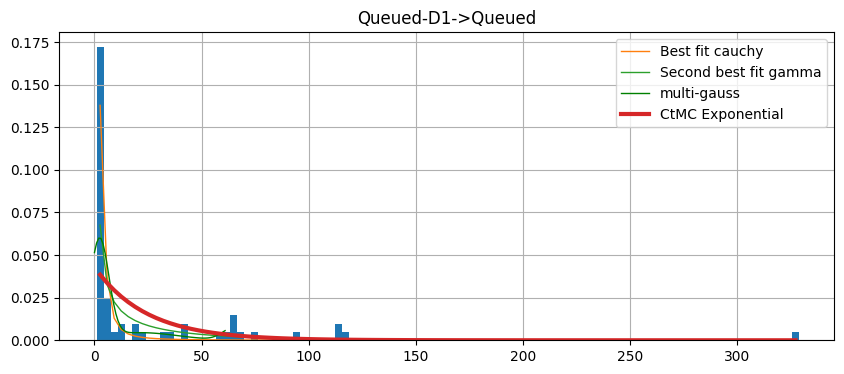

2025-05-01 11:13:59.118 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.001469)
2025-05-01 11:13:59.119 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.002423)
2025-05-01 11:13:59.120 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.002163)
2025-05-01 11:13:59.120 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.00224)
2025-05-01 11:13:59.121 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000956)
2025-05-01 11:13:59.124 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.00125)
2025-05-01 11:13:59.125 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.00179)
2025-05-01 11:13:59.139 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted g

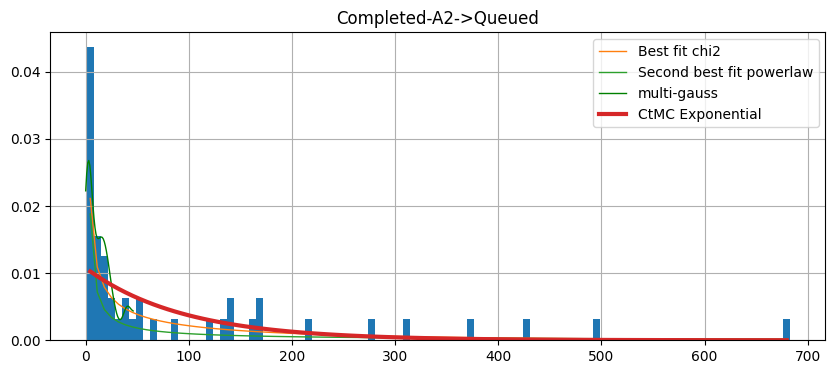

2025-05-01 11:14:02.003 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.005467)
2025-05-01 11:14:02.005 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.007146)
2025-05-01 11:14:02.005 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.00694)
2025-05-01 11:14:02.005 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.00728)
2025-05-01 11:14:02.007 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.005523)
2025-05-01 11:14:02.008 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.003456)
2025-05-01 11:14:02.008 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.006107)
2025-05-01 11:14:02.024 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

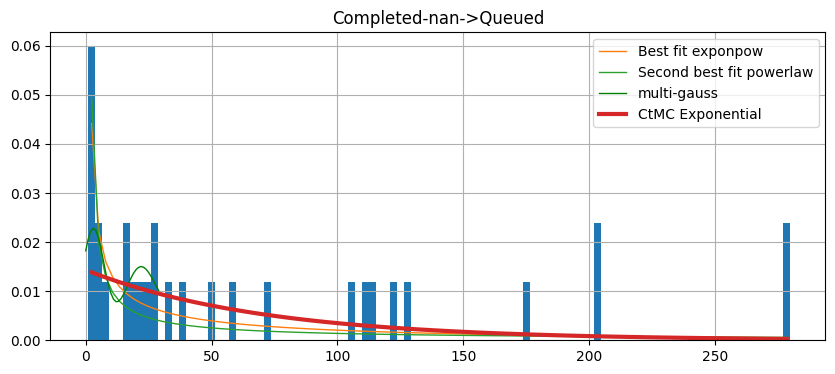

2025-05-01 11:14:02.823 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.012193)
2025-05-01 11:14:02.826 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.015166)
2025-05-01 11:14:02.826 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.014867)
2025-05-01 11:14:02.827 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.007175)
2025-05-01 11:14:02.828 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.01312)
2025-05-01 11:14:02.829 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.014608)
2025-05-01 11:14:02.829 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.012183)
2025-05-01 11:14:02.845 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

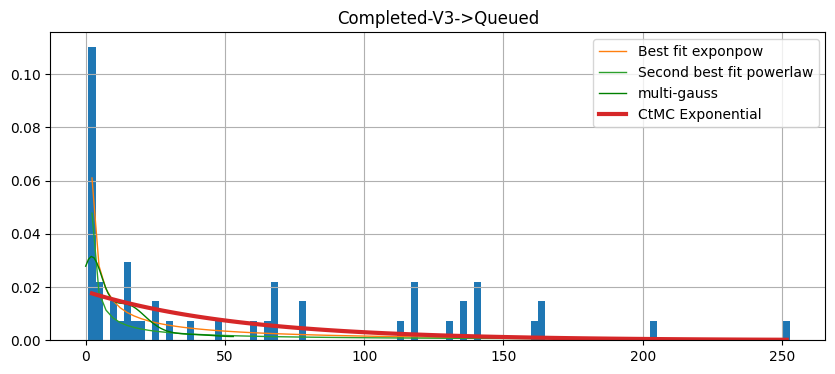

2025-05-01 11:14:03.818 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.001713)
2025-05-01 11:14:03.820 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.003046)
2025-05-01 11:14:03.820 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.002537)
2025-05-01 11:14:03.821 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.002665)
2025-05-01 11:14:03.822 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.001954)
2025-05-01 11:14:03.822 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000962)
2025-05-01 11:14:03.823 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.002192)
2025-05-01 11:14:03.846 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

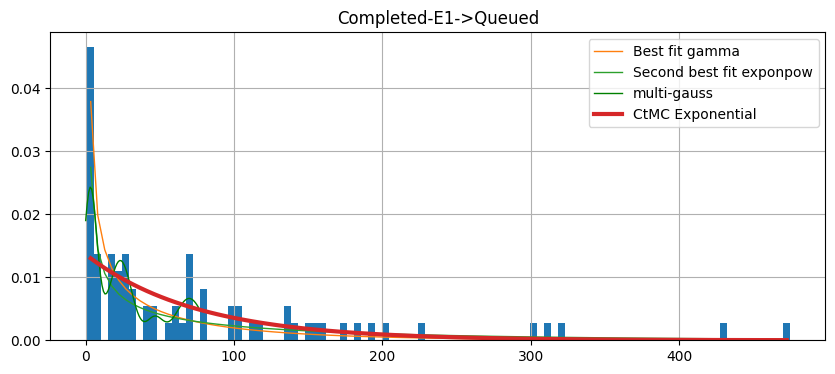

2025-05-01 11:14:09.476 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.23464)
2025-05-01 11:14:09.477 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.241968)
2025-05-01 11:14:09.477 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.241248)
2025-05-01 11:14:09.478 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.240299)
2025-05-01 11:14:09.478 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.242207)
2025-05-01 11:14:09.479 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.225677)
2025-05-01 11:14:09.481 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.195007)
2025-05-01 11:14:09.506 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

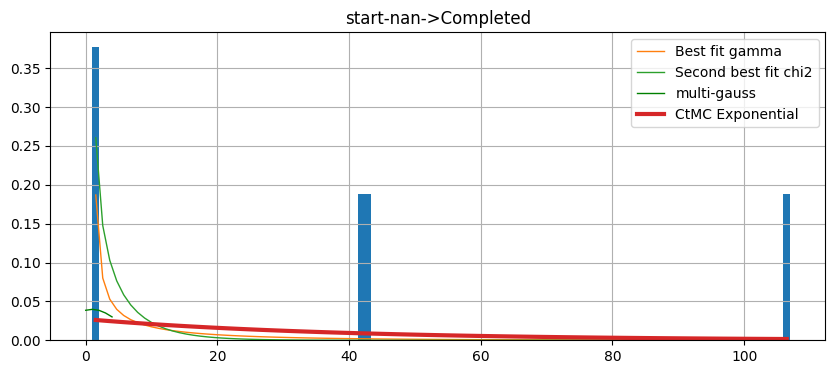

2025-05-01 11:14:09.845 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=nan)
2025-05-01 11:14:09.846 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=nan)
2025-05-01 11:14:09.847 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=nan)
2025-05-01 11:14:09.851 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED gamma distribution (taking more than 30 seconds)
2025-05-01 11:14:09.855 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=10000.0)
2025-05-01 11:14:09.857 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=10000.0)
2025-05-01 11:14:09.875 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=10000.0)
2025-05-01 11:14:09.875 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 dis

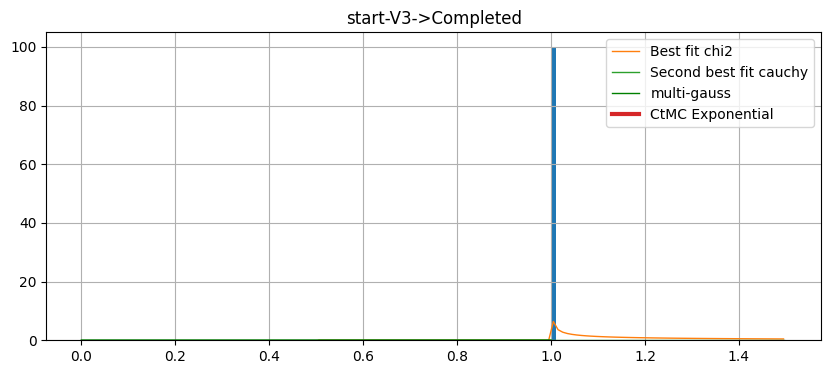

2025-05-01 11:14:10.201 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.01678)
2025-05-01 11:14:10.203 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.016918)
2025-05-01 11:14:10.204 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.01684)
2025-05-01 11:14:10.206 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.016861)
2025-05-01 11:14:10.206 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.01676)
2025-05-01 11:14:10.206 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.016442)
2025-05-01 11:14:10.207 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.01563)
2025-05-01 11:14:10.228 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted ch

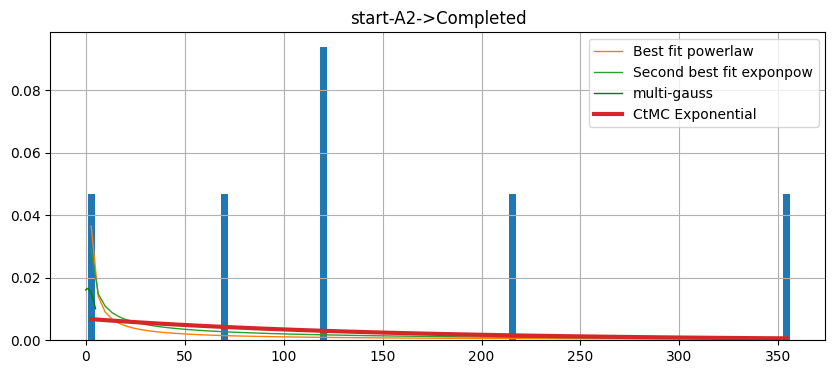

2025-05-01 11:14:10.562 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4.6e-05)
2025-05-01 11:14:10.564 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000108)
2025-05-01 11:14:10.565 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000101)
2025-05-01 11:14:10.566 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000131)
2025-05-01 11:14:10.568 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=6.6e-05)
2025-05-01 11:14:10.568 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.8e-05)
2025-05-01 11:14:10.569 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=9.9e-05)
2025-05-01 11:14:10.595 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted ga

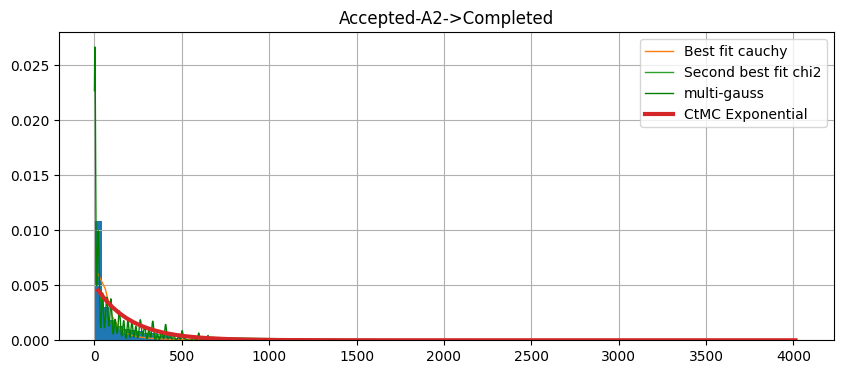

2025-05-01 11:14:18.052 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000226)
2025-05-01 11:14:18.052 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=9.9e-05)
2025-05-01 11:14:18.053 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000285)
2025-05-01 11:14:18.053 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.00021)
2025-05-01 11:14:18.056 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000145)
2025-05-01 11:14:18.056 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000122)
2025-05-01 11:14:18.058 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000221)
2025-05-01 11:14:18.085 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

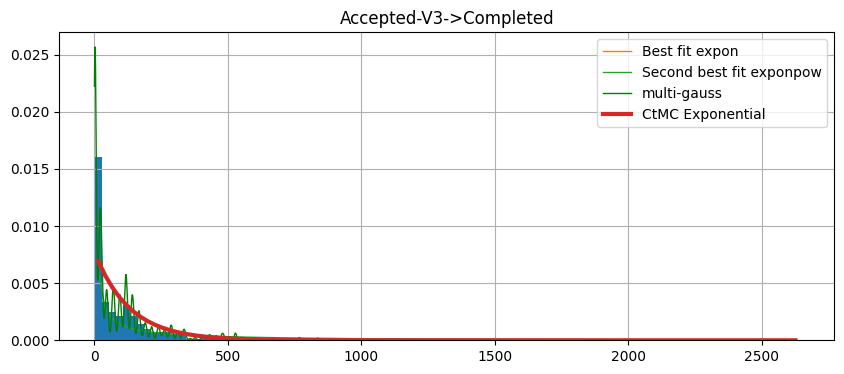

2025-05-01 11:14:26.069 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=2.7e-05)
2025-05-01 11:14:26.070 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=6.8e-05)
2025-05-01 11:14:26.072 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=8.1e-05)
2025-05-01 11:14:26.073 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=6.3e-05)
2025-05-01 11:14:26.073 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=6.4e-05)
2025-05-01 11:14:26.073 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2e-06)
2025-05-01 11:14:26.075 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=4.8e-05)
2025-05-01 11:14:26.098 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma d

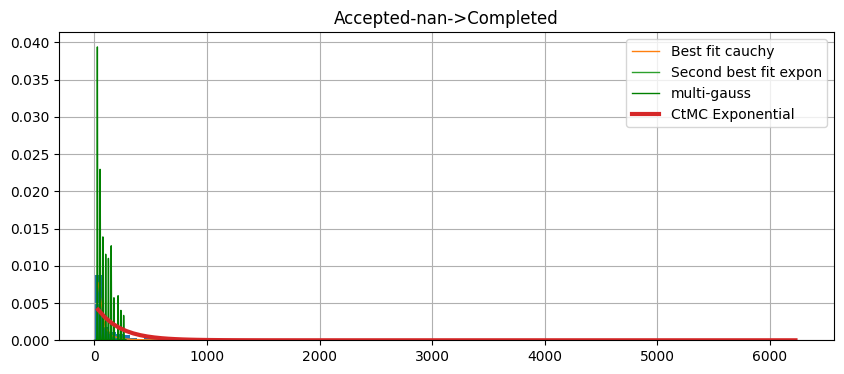

2025-05-01 11:14:30.387 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=4.9e-05)
2025-05-01 11:14:30.388 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=8.3e-05)
2025-05-01 11:14:30.389 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=9e-05)
2025-05-01 11:14:30.390 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=8e-05)
2025-05-01 11:14:30.392 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=5e-05)
2025-05-01 11:14:30.393 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=7.4e-05)
2025-05-01 11:14:30.394 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=4.8e-05)
2025-05-01 11:14:30.407 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distri

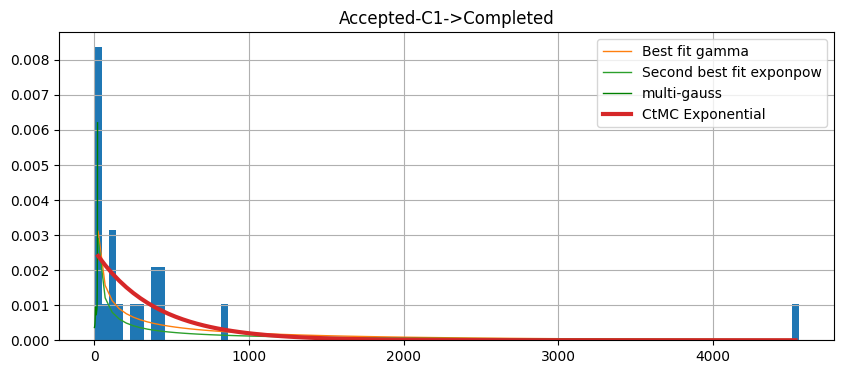

2025-05-01 11:14:40.862 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000136)
2025-05-01 11:14:40.862 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000301)
2025-05-01 11:14:40.863 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.00038)
2025-05-01 11:14:40.863 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000281)
2025-05-01 11:14:40.866 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000107)
2025-05-01 11:14:40.868 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000303)
2025-05-01 11:14:40.869 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000213)
2025-05-01 11:14:40.882 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

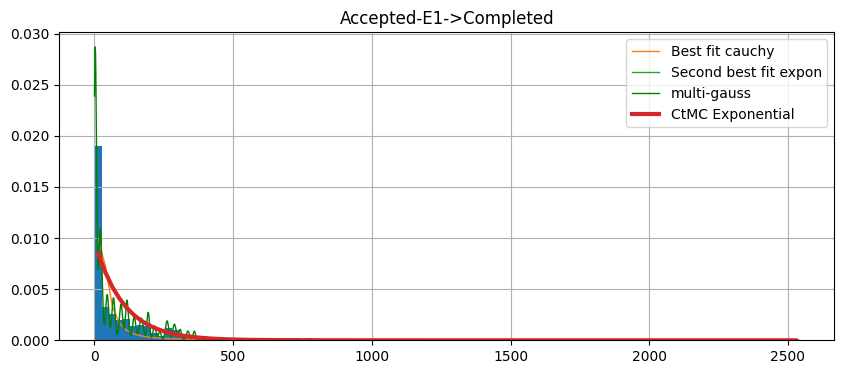

2025-05-01 11:14:48.530 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=6.6e-05)
2025-05-01 11:14:48.532 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000138)
2025-05-01 11:14:48.532 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000148)
2025-05-01 11:14:48.532 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000184)
2025-05-01 11:14:48.534 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=8.9e-05)
2025-05-01 11:14:48.535 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000104)
2025-05-01 11:14:48.536 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=6.2e-05)
2025-05-01 11:14:48.553 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted g

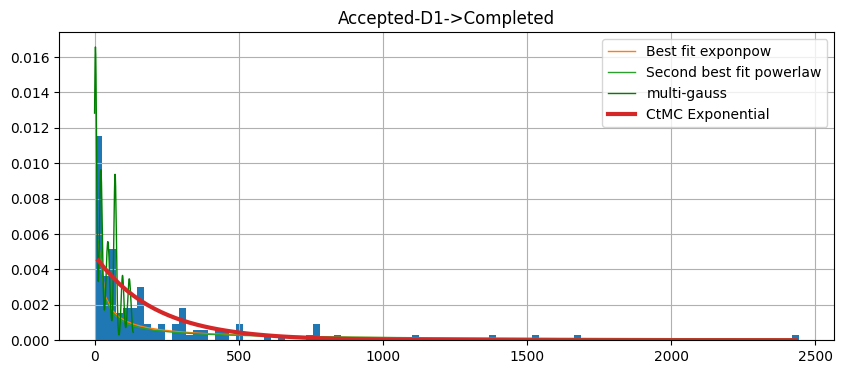

2025-05-01 11:14:52.775 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.00355)
2025-05-01 11:14:52.776 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.003988)
2025-05-01 11:14:52.777 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.00381)
2025-05-01 11:14:52.778 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.003224)
2025-05-01 11:14:52.778 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.003815)
2025-05-01 11:14:52.782 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.003286)
2025-05-01 11:14:52.783 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.002026)
2025-05-01 11:14:52.813 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

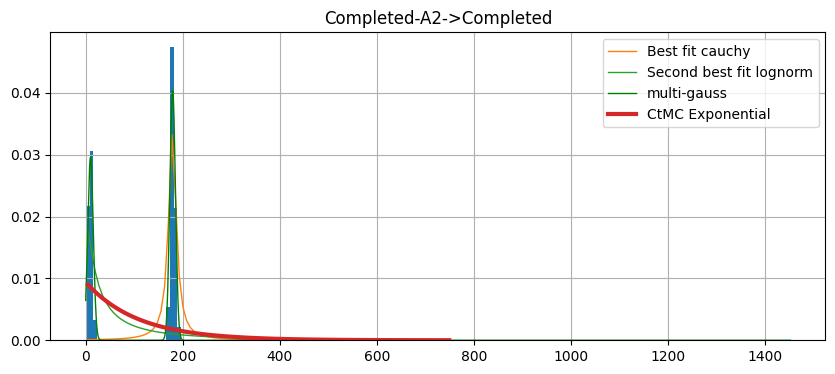

2025-05-01 11:14:53.242 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.004271)
2025-05-01 11:14:53.243 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.004598)
2025-05-01 11:14:53.243 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.004423)
2025-05-01 11:14:53.243 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.004384)
2025-05-01 11:14:53.243 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.004075)
2025-05-01 11:14:53.247 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.00128)
2025-05-01 11:14:53.249 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.003979)
2025-05-01 11:14:53.278 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

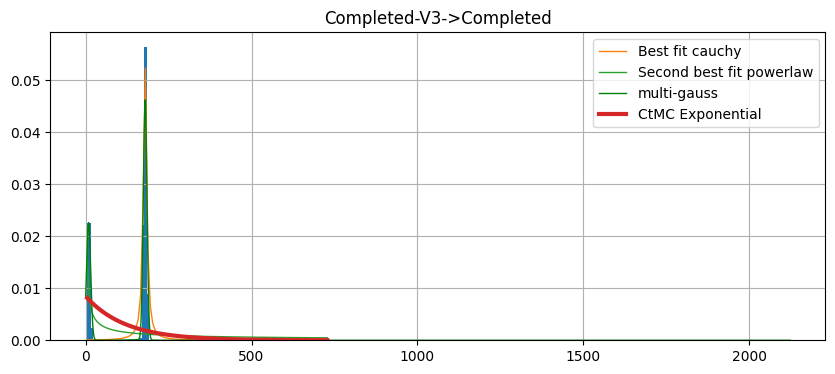

2025-05-01 11:14:53.780 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.007513)
2025-05-01 11:14:53.783 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.007153)
2025-05-01 11:14:53.783 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.007626)
2025-05-01 11:14:53.783 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.007153)
2025-05-01 11:14:53.785 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.007392)
2025-05-01 11:14:53.786 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000847)
2025-05-01 11:14:53.786 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.007488)
2025-05-01 11:14:53.813 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

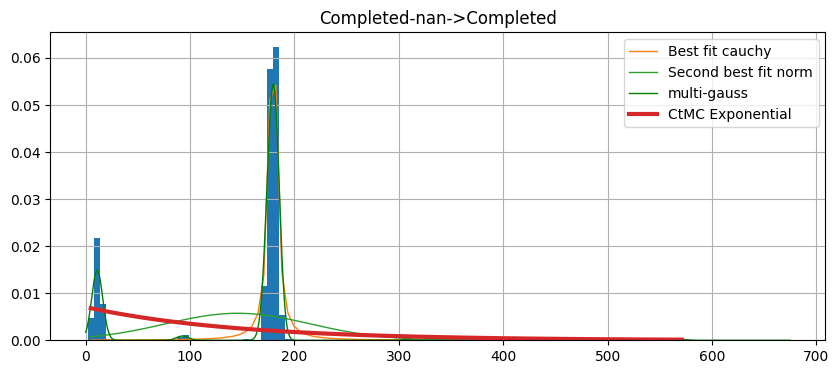

2025-05-01 11:14:55.087 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.032036)
2025-05-01 11:14:55.088 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.030684)
2025-05-01 11:14:55.088 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.030521)
2025-05-01 11:14:55.089 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.031642)
2025-05-01 11:14:55.089 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.030337)
2025-05-01 11:14:55.090 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.030048)
2025-05-01 11:14:55.091 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.009534)
2025-05-01 11:14:55.108 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitte

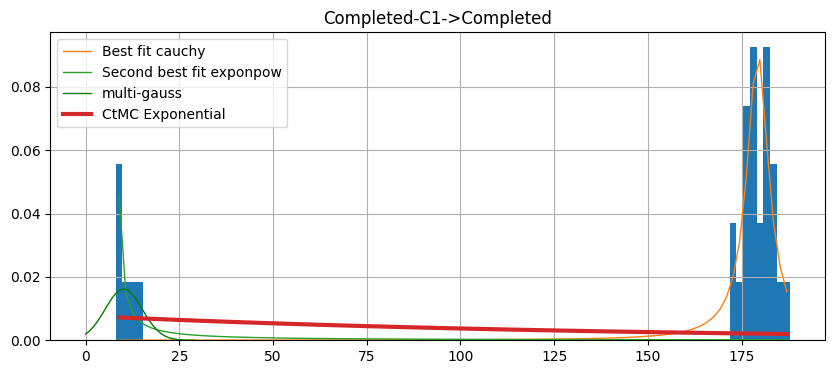

2025-05-01 11:14:55.431 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.003947)
2025-05-01 11:14:55.432 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.003747)
2025-05-01 11:14:55.433 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.004109)
2025-05-01 11:14:55.435 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.003747)
2025-05-01 11:14:55.435 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.003892)
2025-05-01 11:14:55.437 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.003875)
2025-05-01 11:14:55.438 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.00053)
2025-05-01 11:14:55.463 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

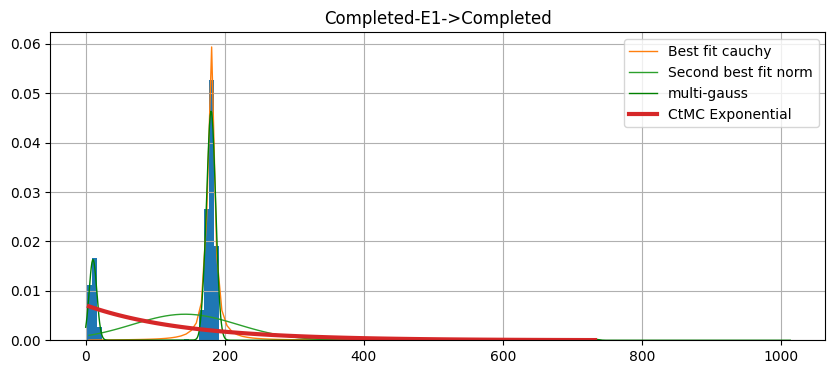

2025-05-01 11:14:55.958 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.035644)
2025-05-01 11:14:55.958 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.031756)
2025-05-01 11:14:55.959 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.03385)
2025-05-01 11:14:55.960 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.034404)
2025-05-01 11:14:55.961 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.031756)
2025-05-01 11:14:55.961 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.010531)
2025-05-01 11:14:55.963 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.022587)
2025-05-01 11:14:55.985 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

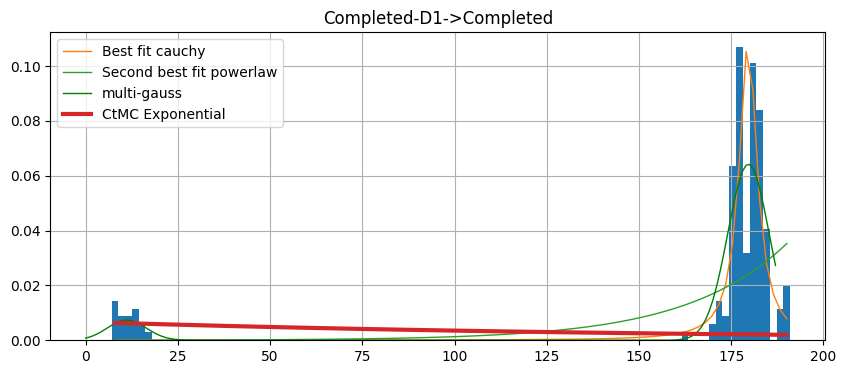

2025-05-01 11:14:56.444 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000209)
2025-05-01 11:14:56.444 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000339)
2025-05-01 11:14:56.445 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000366)
2025-05-01 11:14:56.446 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000328)
2025-05-01 11:14:56.448 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=3.7e-05)
2025-05-01 11:14:56.449 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=5.6e-05)
2025-05-01 11:14:56.451 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.000188)
2025-05-01 11:14:56.465 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

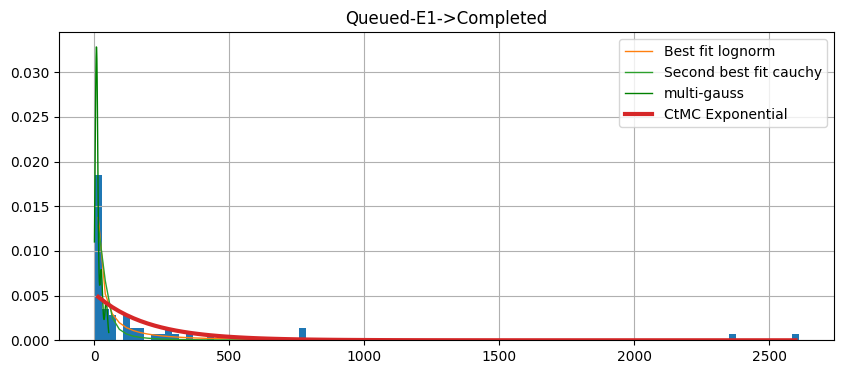

2025-05-01 11:15:00.369 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=2.7e-05)
2025-05-01 11:15:00.371 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=5e-05)
2025-05-01 11:15:00.371 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=5.4e-05)
2025-05-01 11:15:00.372 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=4.8e-05)
2025-05-01 11:15:00.372 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=3.8e-05)
2025-05-01 11:15:00.374 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=9e-06)
2025-05-01 11:15:00.375 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=2.8e-05)
2025-05-01 11:15:00.391 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 dist

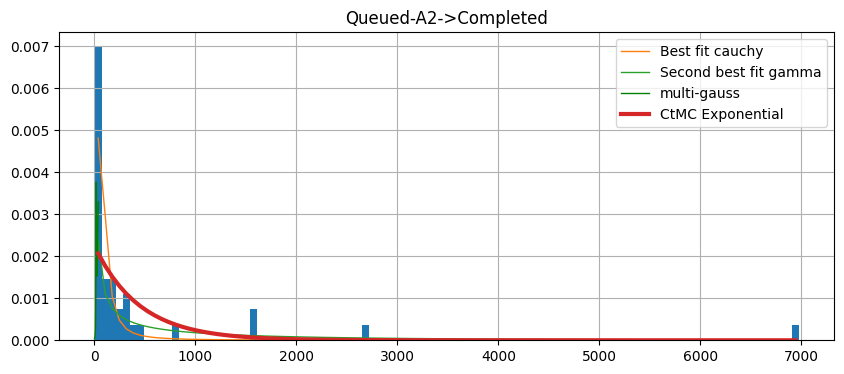

2025-05-01 11:15:27.932 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000547)
2025-05-01 11:15:27.934 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000793)
2025-05-01 11:15:27.935 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.000822)
2025-05-01 11:15:27.936 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000773)
2025-05-01 11:15:27.938 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000189)
2025-05-01 11:15:27.939 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000668)
2025-05-01 11:15:27.942 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.00045)
2025-05-01 11:15:27.961 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

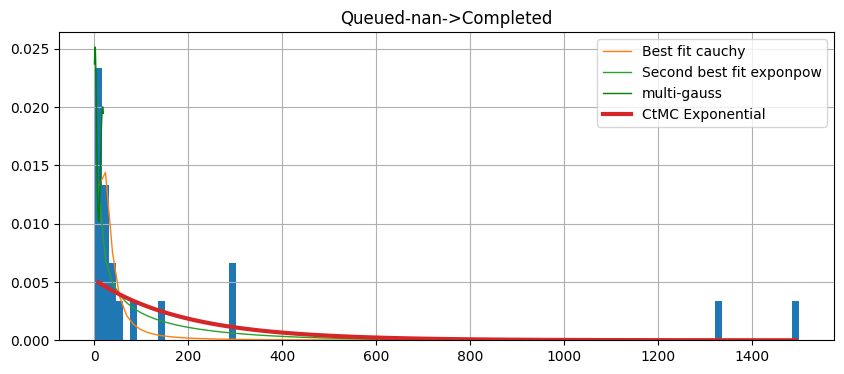

2025-05-01 11:15:28.609 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.000531)
2025-05-01 11:15:28.610 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.000905)
2025-05-01 11:15:28.611 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.001009)
2025-05-01 11:15:28.613 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.000868)
2025-05-01 11:15:28.615 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.000862)
2025-05-01 11:15:28.616 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.000279)
2025-05-01 11:15:28.617 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.00061)
2025-05-01 11:15:28.637 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

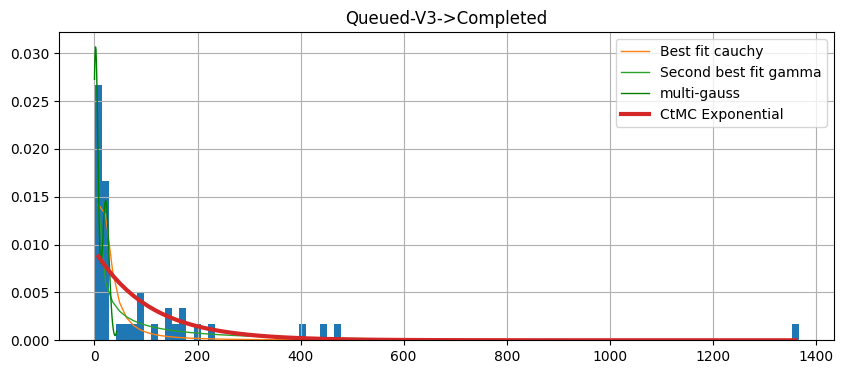

2025-05-01 11:15:31.927 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=0.33839)
2025-05-01 11:15:31.935 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.343735)
2025-05-01 11:15:31.948 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=0.340278)
2025-05-01 11:15:31.948 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=0.343476)
2025-05-01 11:15:31.949 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=0.297227)
2025-05-01 11:15:31.950 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.325561)
2025-05-01 11:15:31.954 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=0.344404)
2025-05-01 11:15:31.983 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted

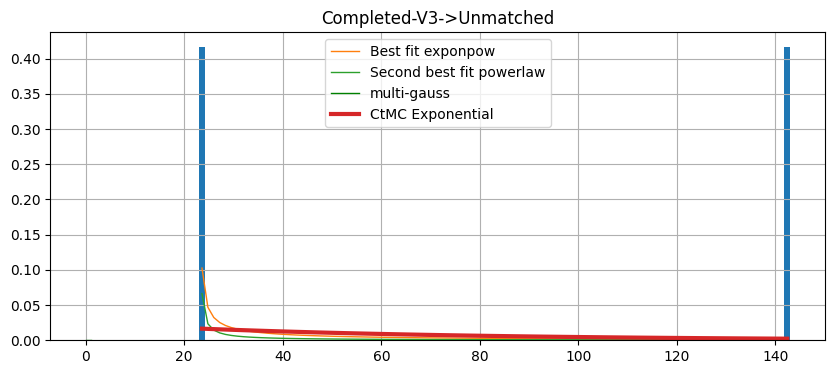

In [43]:
eval_functions = pd.DataFrame()

seed=None

for k, v in times_dictionary.items():
    s1 = k[0]
    s2 = k[1]
    role = k[2]
    v = np.array(v)
    v = v // 3600
    # do we remove 0 values?
    v = v[v != 0]
    #Note: on invalid values the fitting will return NaN. This means there was no fit.
    if len(v) > 1:# and role in ['V3']:
        x = [i for i in range(len(v))]

        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

        f = fitter.Fitter(v,distributions=fitter.get_common_distributions())
        f.fit()
        best_dist, fitted_params = f.get_best().popitem()
        best_two_summary = f.summary(Nbest=2,plot=True,lw=1)

        test_func = getattr(scipy.stats, best_dist)
        test_res = test_func.pdf(x, **fitted_params)
        best_two_summary.loc[best_dist,'kl_div'] = kl_div(test_res,v)
        second_best = best_two_summary.index[1]
        test_func = getattr(scipy.stats, second_best)
        test_res = test_func.pdf(x, *f.fitted_param[second_best])
        best_two_summary.loc[second_best,'kl_div'] = kl_div(test_res,v)

        kde = sm.nonparametric.KDEUnivariate(v)
        kde.fit(bw=4, kernel='gau')  # Estimate the densities
        multi_gauss = fit_gauss(kde.support, kde.density, v)
        multi_gauss.plot_mult_gauss(x,label='multi-gauss',color='g')
        ks_stat, ks_pval, kl_divergence = multi_gauss.fitted_results(v)
        best_two_summary.loc['multi-gauss'] = [np.inf,np.inf,np.inf,kl_divergence,ks_stat,ks_pval]

        f = fitter.Fitter(v,distributions=['expon'])
        f.fit()

        f.plot_pdf(names=['expon'],lw=3)
        expon_summary = f.summary(Nbest=1,plot=False)
        best_expon, fitted_expon = f.get_best().popitem()
        res = stats.expon.pdf(x, **fitted_expon)
        expon_summary.loc['expon','kl_div'] = kl_div(res,v)
        expon_summary.rename({'expon':'_expon'},axis=0,inplace=True)

        # plt.xlim([0,500])
        plt.title(f'{s1}-{role}->{s2}')
        plt.legend(labels=[f'Best fit {best_two_summary.index[0]}',f'Second best fit {best_two_summary.index[1]}','multi-gauss',f'CtMC Exponential'])
        plt.savefig(f"/home/vco/Writing/simulation/figs/timeeval/{s1}-{role}-{s2}.png",format='png',pad_inches=0)
        plt.show()

        fit_summary = pd.concat([expon_summary, best_two_summary])
        fit_summary['from'] = s1
        fit_summary['to'] = s2
        fit_summary['role'] = role
        eval_functions = pd.concat([eval_functions,fit_summary])
        # break

In [44]:
kl_div_eval = deepcopy(eval_functions[['kl_div','from','role','to']])

In [45]:
clean_kl_div_eval = kl_div_eval[(kl_div_eval['from']!='start') & (kl_div_eval['kl_div'].notna())]

In [46]:
clean_kl_div_eval['kl_div'].groupby(clean_kl_div_eval.index).mean()

_expon         1.846484
cauchy         2.760857
chi2           4.626535
expon          2.333691
exponpow       4.235795
gamma          5.093609
lognorm        1.721124
multi-gauss    2.391987
norm           1.796225
powerlaw       4.370565
Name: kl_div, dtype: float64

In [47]:
kl_div_res = clean_kl_div_eval.groupby(clean_kl_div_eval.index).apply(lambda x: x['kl_div'].tolist()).to_dict()

In [48]:
kl_divergence_values = kl_div_res['_expon']
print(kl_divergence_values)
kl_divergence_average = np.mean(list(kl_divergence_values))
print("KL-divergence average:")
print(kl_divergence_average)
kl_divergence_interval = stats.t.interval(0.95, df=len(kl_divergence_values) - 1,
                                       loc=np.mean(list(kl_divergence_values)),
                                       scale=stats.sem(list(kl_divergence_values)))
print("KL-divergence interval:")
print(kl_divergence_interval[1] - kl_divergence_average)
print()

[2.5433624906705536, 3.28929389135173, 1.7171629253311131, 3.402342180931022, 2.603406590822245, 1.936554393271175, 3.0269343918537617, 3.8237621671328186, 1.6102676379929317, 3.1027215798002845, 2.6190588086234703, 2.1744826054128104, 0.9549095204760979, 1.0465624914256717, 1.2034449849706113, 1.1406382069508316, 1.1801381685669265, 2.5947565905483265, 2.2546193683552156, 1.852220001575369, 2.3151713849756796, 2.3082189098885824, 1.6225793440693952, 2.6088736402477855, 2.099383704045537, 2.031343525853091, 2.1393511520329653, 2.4964940137862395, 1.4483215508092835, 1.3246351184732807, 0.8714393952533991, 1.1482641411737242, 0.9758913034186133, 0.9300951527671008, 0.9368481431116517, 1.384827707599711, 2.1498281499837684, 0.989338545575863, 1.012842109356417, 2.246777624870678, 2.7949788851503174, 1.0511042084895015, 0.6297443930598905, 1.6367764794568076, 0.28454875717805433, 1.663245599934878, 1.7717598413950555, 1.8207515959559477, 1.7076181606699048]
KL-divergence average:
1.846483

In [49]:
kl_divergence_values = kl_div_res['multi-gauss']
print(kl_divergence_values)
kl_divergence_average = np.mean(list(kl_divergence_values))
print("KL-divergence average:")
print(kl_divergence_average)
kl_divergence_interval = stats.t.interval(0.95, df=len(kl_divergence_values) - 1,
                                       loc=np.mean(list(kl_divergence_values)),
                                       scale=stats.sem(list(kl_divergence_values)))
print("KL-divergence interval:")
print(kl_divergence_interval[1] - kl_divergence_average)
print()

[3.256231383415403, 3.8399687607309865, 2.825233956520364, 3.8305506493612658, 3.837827903529301, 2.62320226298731, 3.2953253518883057, 3.7870518457114706, 1.9038728477637592, 3.1850293277731536, 3.0533693482919855, 2.1112700668877618, 1.20024210277378, 1.3132753302384512, 1.3983492259469383, 0.7573320683916557, 1.262889584189687, 6.092322670406311, 2.4982113918771285, 1.6702294652976448, 2.4459212809983524, 3.9837240831791494, 2.0866536166093543, 3.0312308257062583, 3.501681477381945, 2.8934441062182574, 2.3543152840770256, 2.4260416785875205, 1.9577441148196706, 1.6032802048317896, 1.1140473432829274, 1.3420657505723232, 1.0994697755056178, 1.098084807185518, 1.1941652106525944, 2.4656048576907144, 2.270882123546701, 1.1093898442047079, 0.8028711092901363, 4.240490606432711, 4.7672757419621465, 4.310930919643557, 0.6831547806266524, 3.9113181460073085, 2.1383252779618878, 1.2405557192377228, 2.2621392578014543, 2.0953311437981963, 1.4140560081635813, 0.01336516703757934]
KL-divergenc